# setup

In [1]:
# Title: 2.5.1_cmip6_clim.ipynb
# heavily based on https://nordicesmhub.github.io/forces-2021/learning/example-notebooks/xesmf_regridding.html
import warnings
warnings.filterwarnings('ignore') # don't output warnings

import os
# import packages
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xesmf as xe
import pandas as pd
import seaborn as sns
import geopandas as gpd
import rioxarray
import cmcrameri.cm
from scipy.stats import entropy
#import xesmf as xe
import regionmask
import cartopy
import dask
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import fsspec
from dask.diagnostics import progress
from xmip.preprocessing import combined_preprocessing
from collections import defaultdict
regions = gpd.read_file(r'Data\regions1.geojson')


In [2]:
from dask.distributed import Client
client = Client()
client

<Client: 'tcp://127.0.0.1:56343' processes=4 threads=8, memory=19.91 GiB>

In [3]:
ibge = gpd.read_file(r'Data\IBGE\BiomasBrasil.shp')
shp_cerrado = ibge[ibge.biomas == 'CERRADO']
bests = ['ACCESS-CM2','CESM2-WACCM','GFDL-CM4','GFDL-ESM4','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','HadGEM3-GC31-LL']
all_models= ['ACCESS-CM2', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0',
   'CAS-ESM2-0', 'CESM2-WACCM', 'CanESM5', 'E3SM-1-1', 'FGOALS-f3-L',
   'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'IITM-ESM',
   'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM',
   'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3',
   'NorESM2-MM']
hue_order = ['Central', 'Southern','Eastern']

In [4]:
regions = gpd.read_file(r'Data\regions1.geojson')
gdf_knn = gpd.read_file('Data\gdf_knn_bet.geojson')
palette = sns.color_palette('cmc.batlow', 3)
cerrado_mask = regionmask.Regions([regions.geometry.values[0], regions.geometry.values[1], regions.geometry.values[2]], names=['Central', 'Southern', 'Eastern'], abbrevs=['C', 'S', 'E'], name = 'Cerrado Regions')


In [5]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

In [6]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df

activity_id       institution_id      source_id       experiment_id  \
0       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
1       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
2       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
3       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
4       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
...            ...                  ...            ...                 ...   
523769        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   
523770        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   
523771        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   
523772        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   
523773        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   

       member_id table_id variable_id grid_label  \
0       r1i1p1f1     Amon          ps         gn   
1       r1i1p1f1     Amon        rsds         gn   
2       r1i1p1f1     Amon        rlus         gn   
3       r1i1p1f1     Amon        rlds         gn   
4       r1i1p1f1     Amon         psl         gn   
...          ...      ...         ...        ...   
523769  r1i1p1f1     Amon         tas         gr   
523770  r1i1p1f1     Amon        tauu         gr   
523771  r1i1p1f1     Amon         hur         gr   
523772  r1i1p1f1     Amon         hus         gr   
523773  r1i1p1f1     Amon        tauv         gr   

                                                   zstore  dcpp_init_year  \
0       gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN   
1       gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN   
2       gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN   
3       gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN   
4       gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN   
...                                                   ...             ...   
523769  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
523770  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
523771  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
523772  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
523773  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   

         version  
0       20170706  
1       20170706  
2       20170706  
3       20170706  
4       20170706  
...          ...  
523769  20211207  
523770  20211207  
523771  20211207  
523772  20211207  
523773  20211207  

[523774 rows x 11 columns]

# test

In [159]:
# there is currently a significant amount of data for these runs
#expts = ['historical']#'ssp245', 'ssp585'
expts = ['historical']#'ssp
query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=['tas'],
    #member_id = 'r1i1p1f1',
    source_id = bests
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

experiment_id  variable_id  table_id
source_id                                            
ACCESS-CM2                   1            1         1
CESM2-WACCM                  1            1         1
GFDL-CM4                     1            1         1
GFDL-ESM4                    1            1         1
HadGEM3-GC31-LL              1            1         1
MIROC6                       1            1         1
MPI-ESM1-2-HR                1            1         1
MPI-ESM1-2-LR                1            1         1
MRI-ESM2-0                   1            1         1

In [129]:
dset_dict = col_subset.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [158]:
#hadgem

query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=['tas'],
    member_id = 'r1i1p1f3',
    source_id = ['HadGEM3-GC31-LL']
   
)

col_subset_had = col.search(require_all_on=["source_id"], **query)
col_subset_had.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()


experiment_id  variable_id  table_id
source_id                                            
HadGEM3-GC31-LL              1            1         1

In [134]:
dset_dict_had = col_subset_had.to_dataset_dict(zarr_kwargs={'use_cftime':True})
#dset_dict['CMIP.MOHC.HadGEM3-GC31-LL.historical.Amon.gn'] = dset_dict_had['CMIP.MOHC.HadGEM3-GC31-LL.historical.Amon.gn']
dset_dict['ScenarioMIP.MOHC.HadGEM3-GC31-LL.ssp585.Amon.gn'] = dset_dict_had['ScenarioMIP.MOHC.HadGEM3-GC31-LL.ssp585.Amon.gn']

In [138]:
ds = dset_dict['ScenarioMIP.MOHC.HadGEM3-GC31-LL.ssp585.Amon.gn']
ds.sel(time=slice('2071', '2100'), lat=slice(-30, 2), lon=slice(292, 322))

<xarray.Dataset>
Dimensions:         (lat: 26, bnds: 2, lon: 16, member_id: 1,
                     dcpp_init_year: 1, time: 360)
Coordinates:
    height          float64 ...
  * lat             (lat) float64 -29.38 -28.12 -26.88 ... -0.625 0.625 1.875
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(26, 2), meta=np.ndarray>
  * lon             (lon) float64 293.4 295.3 297.2 299.1 ... 317.8 319.7 321.6
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(16, 2), meta=np.ndarray>
  * time            (time) object 2071-01-16 00:00:00 ... 2100-12-16 00:00:00
    time_bnds       (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f3'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: bnds
Data variables:
    tasmin          (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 360, 26, 16), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             59400.0
    branch_time_in_parent:            59400.0
    cmor_version:                     3.4.0
    ...                               ...
    intake_esm_attrs:variable_id:     tasmin
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/ScenarioMIP/MOHC/HadGE...
    intake_esm_attrs:version:         20200114
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           ScenarioMIP.MOHC.HadGEM3-GC31-LL.ssp585...

<GeoAxesSubplot: title={'center': 'height = 1.5 [m], time = 2071-01-16 00:00:00, m...'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

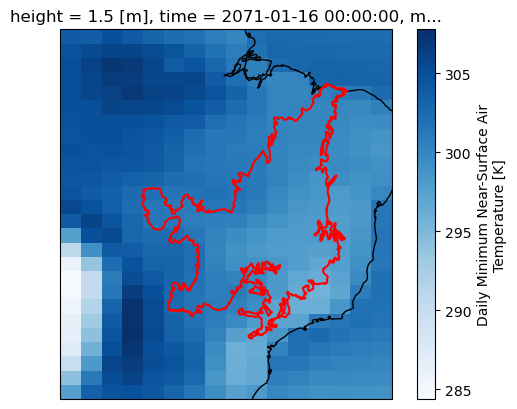

In [140]:
#ds = dset_dict['CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn']
#ds = ds.sel(time=slice('1981', '2010'), lat=slice(-30, 2), lon=slice(292, 322))
ds = dset_dict['ScenarioMIP.MOHC.HadGEM3-GC31-LL.ssp585.Amon.gn']
ds = ds.sel(time=slice('2071', '2100'), lat=slice(-30, 2), lon=slice(292, 322))
ax = plt.axes(projection=ccrs.PlateCarree(), frameon=True)
ax.coastlines()
ds.isel(time=0).tasmin.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')
#plot cerrado shape file
shp_cerrado.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='red')

In [151]:
#ds = dset_dict['CMIP.MOHC.HadGEM3-GC31-LL.historical.Amon.gn']
#ds_out = ds.sel(time=slice('1981', '2010'), lat=slice(-30, 2), lon=slice(292, 322)).squeeze().drop('member_id')
ds = dset_dict['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn']
ds_out = ds.sel(time=slice('2071', '2100'), lat=slice(-30, 2), lon=slice(292, 322)).squeeze().drop('member_id')

In [150]:
ds_regrid_dict = dict()
for key in dset_dict.keys():
    print(key)
    ds_in = dset_dict[key].sortby('time')
    #ds_in['time'] = ds_in.time.values.astype('datetime64[ns]')
    ds_in = ds_in.sel(time=slice('2071', '2100'), lat=slice(-30, 2), lon=slice(292, 322)).squeeze().drop('member_id')
    #ds_in = ds_in.sel(time=slice('1981', '2010'), lat=slice(-30, 2), lon=slice(292, 322)).squeeze().drop('member_id')
    ds_in['time'] = ds_out['time']
    regridder = xe.Regridder(ds_in, ds_out[['lat','lon']], 'bilinear')
    # Apply regridder to data
    # the entire dataset can be processed at once
    ds_in_regrid = regridder(ds_in, keep_attrs=True)
    # Save to netcdf file
    model = key.split('.')[2]


    # create dataset with all models
    ds_regrid_dict[model] = ds_in_regrid
    #print('file written: {}'.format(nc_out))

ScenarioMIP.MRI.MRI-ESM2-0.ssp585.Amon.gn
ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp585.Amon.gr1
ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp585.Amon.gn
ScenarioMIP.NOAA-GFDL.GFDL-CM4.ssp585.Amon.gr1
ScenarioMIP.MIROC.MIROC6.ssp585.Amon.gn
ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn


ValueError: conflicting sizes for dimension 'time': length 360 on 'time' and length 0 on {'lat': 'lat', 'nbnd': 'lat_bnds', 'lon': 'lon', 'time': 'tasmin'}

In [23]:
_ds = list(ds_regrid_dict.values())
_coord = list(ds_regrid_dict.keys())
ds_out_regrid = xr.concat(objs=_ds, dim=_coord, coords='minimal',compat='override').rename({'concat_dim':'model'})
ds_out_regrid

<xarray.Dataset>
Dimensions:         (model: 9, time: 360, lat: 26, lon: 16, bnds: 2)
Coordinates:
    height          float64 1.5
  * time            (time) object 1981-01-16 00:00:00 ... 2010-12-16 00:00:00
    time_bnds       (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    dcpp_init_year  float64 nan
  * lat             (lat) float64 -29.38 -28.12 -26.88 ... -0.625 0.625 1.875
  * lon             (lon) float64 293.4 295.3 297.2 299.1 ... 317.8 319.7 321.6
  * bnds            (bnds) float64 1.0 2.0
  * model           (model) object 'MIROC6' 'MRI-ESM2-0' ... 'HadGEM3-GC31-LL'
Data variables:
    tas             (model, time, lat, lon) float32 dask.array<chunksize=(1, 168, 26, 16), meta=np.ndarray>
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/hist...
    intake_esm_attrs:version:         20181212
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MIROC.MIROC6.historical.Amon.gn
    regrid_method:                    bilinear

In [24]:
#drop dims that are not time, lat,lon, model
dims_out = set(ds_out_regrid.dims) - {'lat', 'lon', 'model', 'time'}

In [25]:
ds_out_regrid = ds_out_regrid.drop_dims(dims_out)

In [26]:
#ds_all_models= ds_out_regrid.drop_dims(['bnds']).drop('dcpp_init_year').load()
ds_all_models= ds_out_regrid.drop(['height', 'dcpp_init_year']).load()

In [27]:
#change from K to celsius
ds_all_models['tas'] = ds_all_models['tas'] - 273.15
#update attrs
ds_all_models['tas'].attrs['units'] = 'celsius'

In [28]:
ds_all_models

<xarray.Dataset>
Dimensions:  (model: 9, time: 360, lat: 26, lon: 16)
Coordinates:
  * time     (time) object 1981-01-16 00:00:00 ... 2010-12-16 00:00:00
  * lat      (lat) float64 -29.38 -28.12 -26.88 -25.62 ... -0.625 0.625 1.875
  * lon      (lon) float64 293.4 295.3 297.2 299.1 ... 315.9 317.8 319.7 321.6
  * model    (model) object 'MIROC6' 'MRI-ESM2-0' ... 'HadGEM3-GC31-LL'
Data variables:
    tas      (model, time, lat, lon) float32 -273.1 -273.1 ... 27.26 27.27
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/hist...
    intake_esm_attrs:version:         20181212
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MIROC.MIROC6.historical.Amon.gn
    regrid_method:                    bilinear

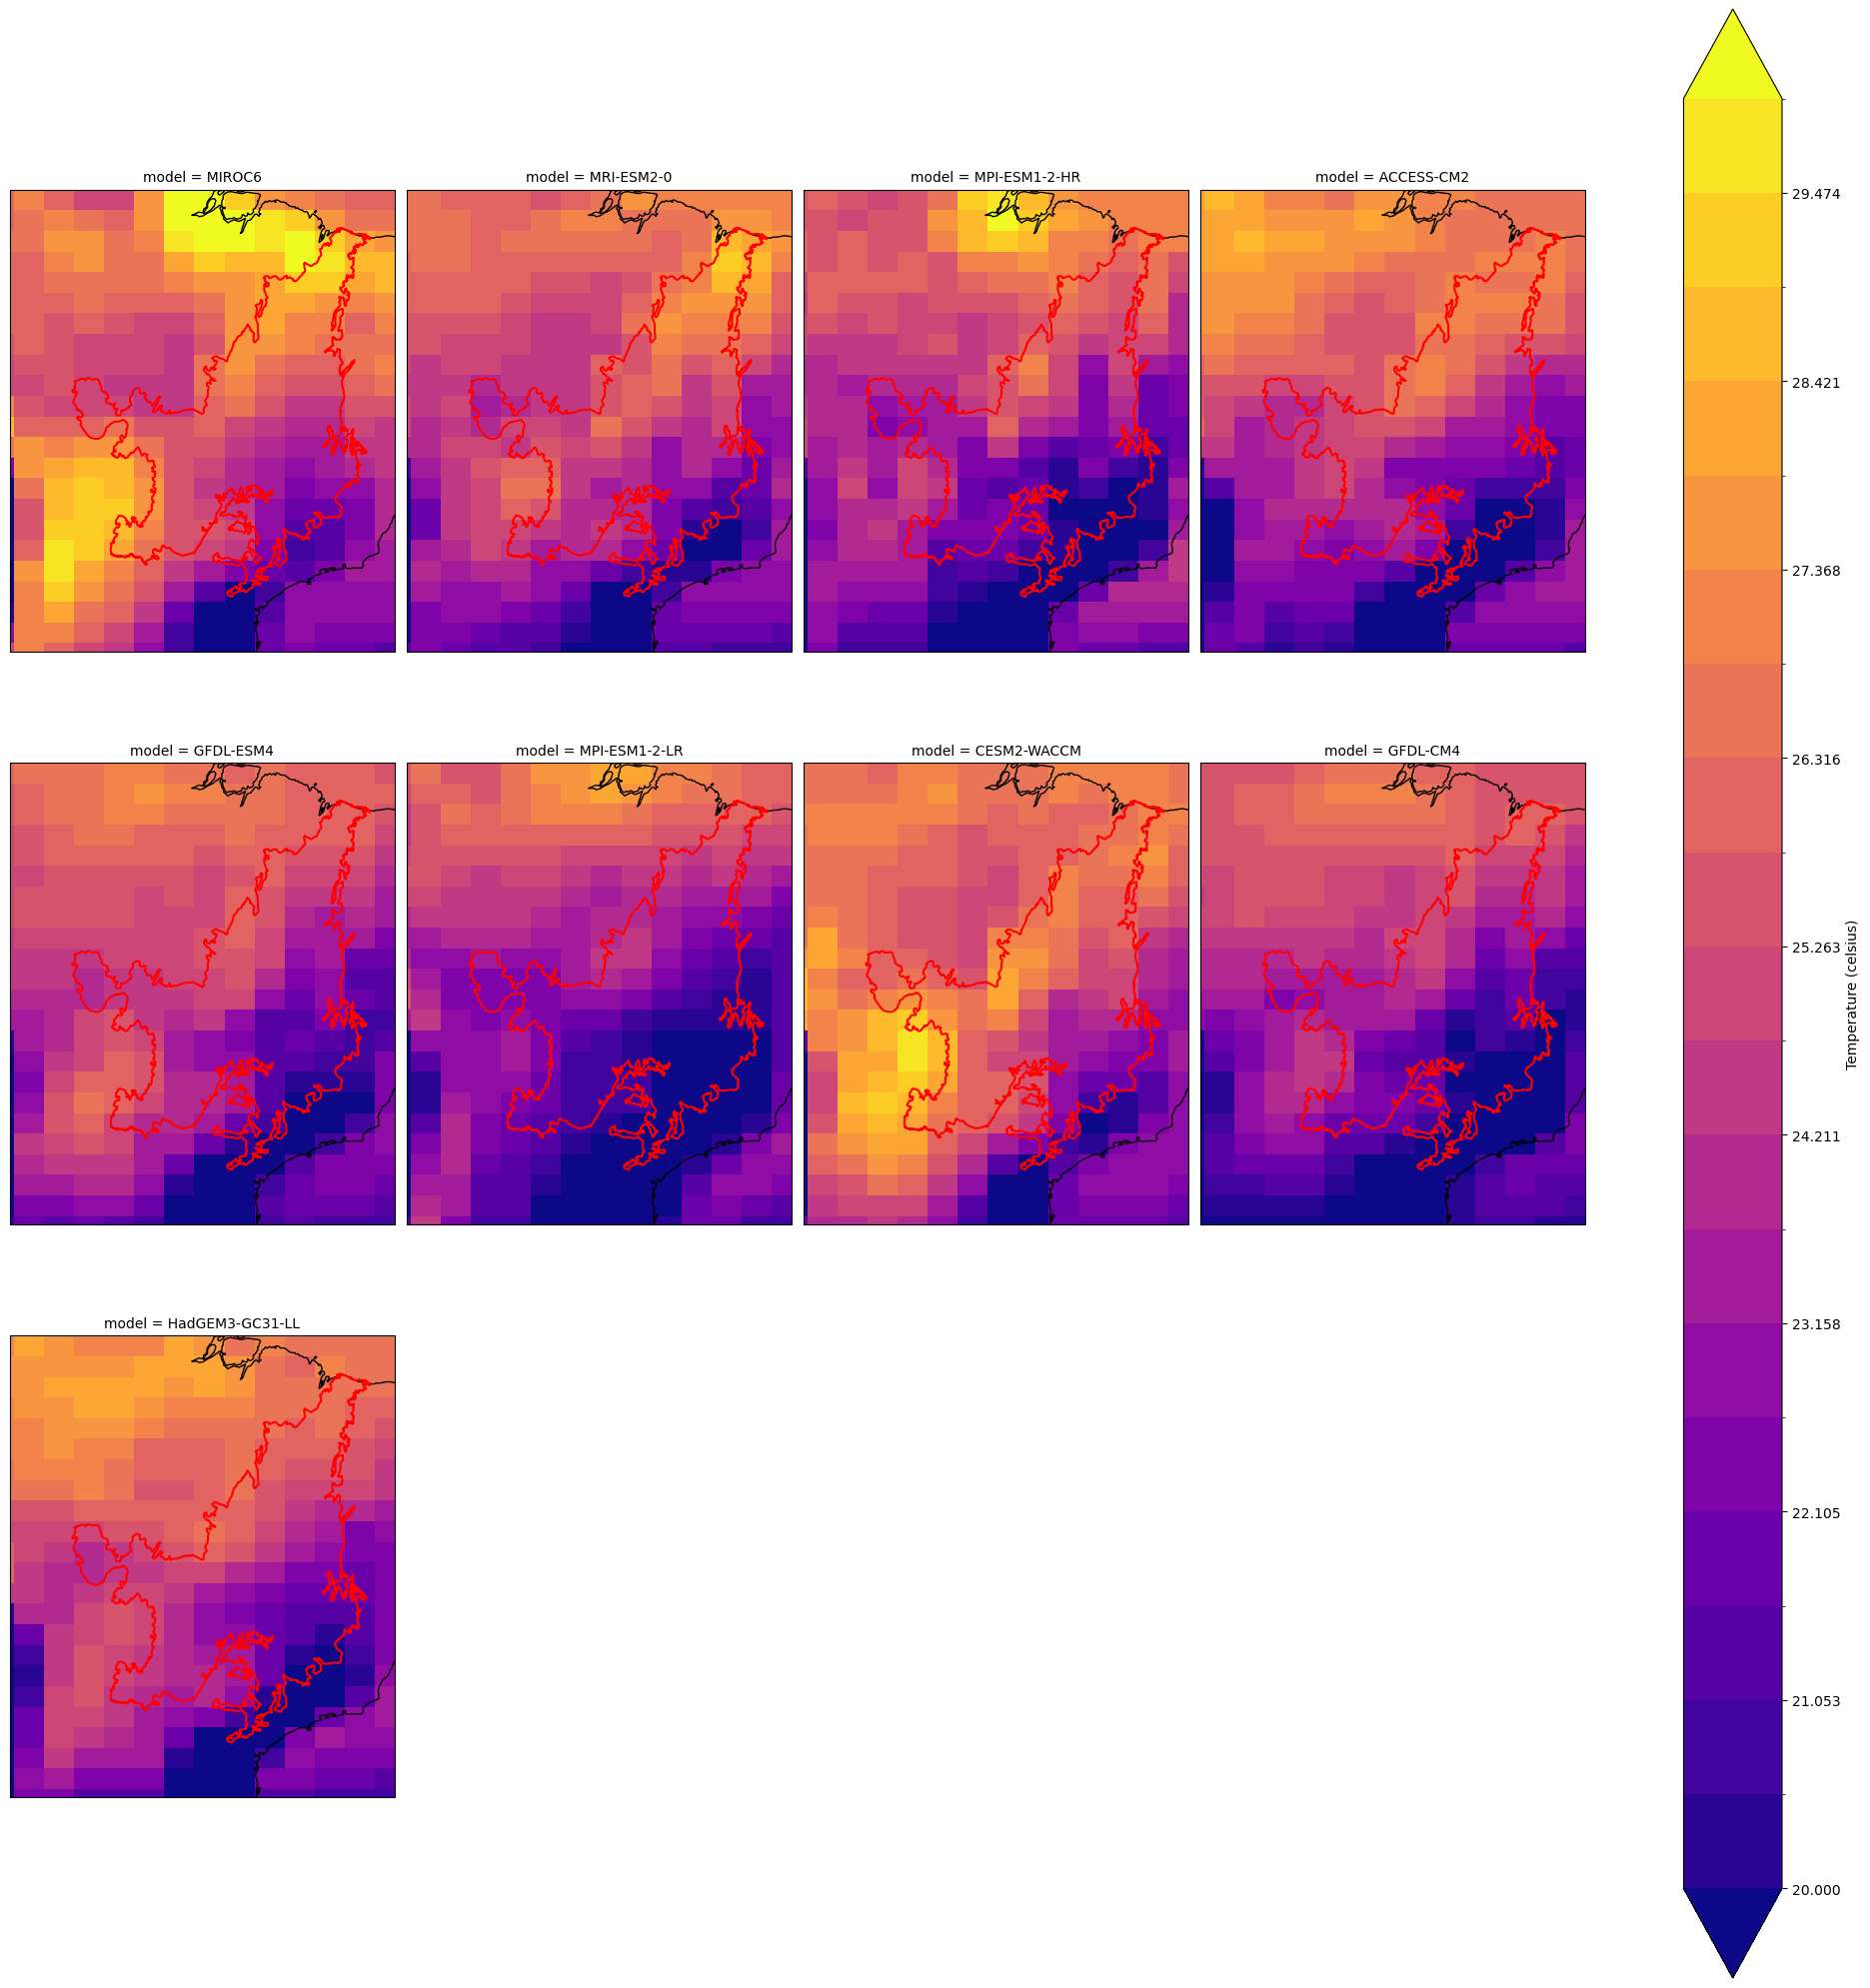

In [32]:
#plot the mean temperature
p = ds_all_models.tas.mean(dim='time').plot(col='model', col_wrap=4, transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.PlateCarree()}, cmap='plasma', vmin=20, vmax=30, cbar_kwargs={'label': 'Temperature (celsius)'}, levels=20, add_colorbar=True, figsize=(20, 20))
for ax in p.axes.flat:
    ax.coastlines()
    shp_cerrado.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='red')
    #set extent
    ax.set_extent([296, 320, -28, 0], crs=ccrs.PlateCarree())

In [230]:
ds_all_models['pr'] = ds_all_models['pr']*86400*30



# function

In [7]:
def ensemble_models(expt, models, var='pr'):
    """
    Function to get data from models and ensemble members
    """
    query = dict(
        experiment_id=expt,
        table_id='Amon',
        variable_id=[var],
        member_id = 'r1i1p1f1',
        source_id = models
    )

    col_subset = col.search(require_all_on=["source_id"], **query)
    col_subset.df.groupby("source_id")[
        ["experiment_id", "variable_id", "table_id"]
    ].nunique()
    dset_dict = col_subset.to_dataset_dict(zarr_kwargs={'use_cftime':True})

    # add HADGEM
    query = dict(
    experiment_id=expt,
    table_id='Amon',
    variable_id=[var],
    member_id = 'r1i1p1f3',
    source_id = ['HadGEM3-GC31-LL']
   
    )

    col_subset_had = col.search(require_all_on=["source_id"], **query)
    col_subset_had.df.groupby("source_id")[
        ["experiment_id", "variable_id", "table_id"]
    ].nunique()
    dset_dict_had = col_subset_had.to_dataset_dict(zarr_kwargs={'use_cftime':True})
    dset_dict[list(dset_dict_had)[-1]] = dset_dict_had[list(dset_dict_had)[-1]]
    return dset_dict

In [8]:
def regrid_models(ensemble, year_start, year_end, grid_out):
    ds = ensemble[grid_out]
    ds_out = ds.sel(time=slice(str(year_start), str(year_end)), lat=slice(-30, 2), lon=slice(292, 322)).squeeze().drop('member_id')

    ds_regrid_dict = dict()
    for key in ensemble.keys():
    
        ds_in = ensemble[key].sortby('time')

        ds_in = ds_in.sel(time=slice(str(year_start), str(year_end)), lat=slice(-30, 2), lon=slice(292, 322)).squeeze().drop('member_id')
        ds_in['time'] = ds_out['time']
        regridder = xe.Regridder(ds_in, ds_out[['lat','lon']], 'bilinear')
        # Apply regridder to data
        # the entire dataset can be processed at once
        ds_in_regrid = regridder(ds_in, keep_attrs=True)
        # Save to netcdf file
        model = key.split('.')[2]


        # create dataset with all models
        ds_regrid_dict[model] = ds_in_regrid

    _ds = list(ds_regrid_dict.values())
    _coord = list(ds_regrid_dict.keys())
    ds_out_regrid = xr.concat(objs=_ds, dim=_coord, coords='minimal',compat='override').rename({'concat_dim':'model'})
    dims_out = set(ds_out_regrid.dims) - {'lat', 'lon', 'model', 'time'}
    ds_regrids= ds_out_regrid.drop_dims(dims_out)
    
    #ds_regrids['pr'] = ds_regrids['pr']*86400*30
    return ds_regrids

## pr

In [43]:
dset_dict = ensemble_models('historical', bests, var='pr')
ds_regridss = regrid_models(dset_dict, 1981, 2010, list(dset_dict)[-1])
ds_regridss['pr'] = ds_regridss['pr']*86400*30
ds_historical_all = ds_regridss.drop('dcpp_init_year').load()
ds_historical_all.to_netcdf('Data\CMIP6\pr_historical_bests_models.nc')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [44]:
dset_dict = ensemble_models('ssp585', bests, var='pr')
ds_regridss = regrid_models(dset_dict, 2071, 2100, list(dset_dict)[-1])
ds_regridss['pr'] = ds_regridss['pr']*86400*30
ds_ssp585_all = ds_regridss.drop('dcpp_init_year').load()
ds_ssp585_all.to_netcdf('Data\CMIP6\pr_ssp585_bests_models.nc')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [45]:
dset_dict245 = ensemble_models('ssp245', bests, var='pr')
ds_regridss = regrid_models(dset_dict245, 2071, 2100, list(dset_dict245)[-1])
ds_regridss['pr'] = ds_regridss['pr']*86400*30
ds_ssp245_all = ds_regridss.drop('dcpp_init_year').load()
ds_ssp245_all.to_netcdf('Data\CMIP6\pr_ssp245_bests_models.nc')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## entropy

In [46]:
def yearly_ratio(x):
    return x / (x.mean(dim='time')*12)

def entropy_models(ds):
    
    ds['ratio'] = ds.groupby('time.year').apply(yearly_ratio).pr
    uniform = np.zeros((12, ds.pr.shape[2], ds.pr.shape[3]))
    uniform[:] = 1/12
    ds['entropy'] = ds.ratio.groupby('time.year').reduce(entropy, qk = uniform, base=2, dim='time')
    return ds[['entropy']]

In [47]:
ds_historical_ent = entropy_models(ds_historical_all)
ds_ssp585_all_ent = entropy_models(ds_ssp585_all)
ds_ssp245_all_ent = entropy_models(ds_ssp245_all)

In [48]:
# save entropy data
ds_historical_ent.to_netcdf('Data\CMIP6\ent_historical_bests_models.nc')
ds_ssp585_all_ent.to_netcdf('Data\CMIP6\ent_ssp585_bests_models.nc')
ds_ssp245_all_ent.to_netcdf('Data\CMIP6\ent_ssp245_bests_models.nc')

In [773]:
ds_historical_ent_clim = ds_historical_ent.sel(model=bests).mean('year').mean('model')
ds_ssp585_all_ent_clim = ds_ssp585_all_ent.sel(model=bests).mean('year').mean('model')
ds_ssp245_all_ent_clim = ds_ssp245_all_ent.sel(model=bests).mean('year').mean('model')

ds_ssp585_ent_anomaly = (ds_ssp585_all_ent_clim - ds_historical_ent_clim)
ds_ssp245_ent_anomaly = (ds_ssp245_all_ent_clim - ds_historical_ent_clim)

<GeoAxesSubplot: xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

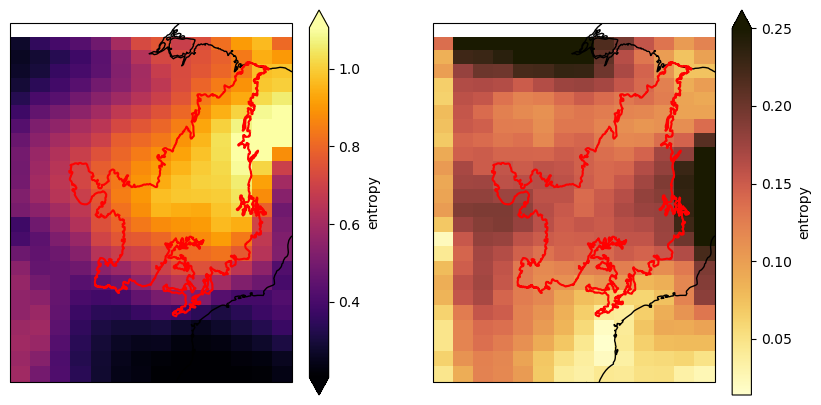

In [774]:
#plot the historical climatology and the anomaly in a subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': proj_plot})
ds_historical_ent_clim.entropy.plot(ax=ax[0], transform=ccrs.PlateCarree(), cmap='inferno', robust=True)
ds_ssp585_ent_anomaly.entropy.plot(cmap='cmc.lajolla', transform=ccrs.PlateCarree(), ax=ax[1], vmax=0.25)
ax[0].coastlines()
ax[1].coastlines()
shp_cerrado.boundary.plot(ax=ax[0], transform=ccrs.PlateCarree(), color='red')
shp_cerrado.boundary.plot(ax=ax[1], transform=ccrs.PlateCarree(), color='red')

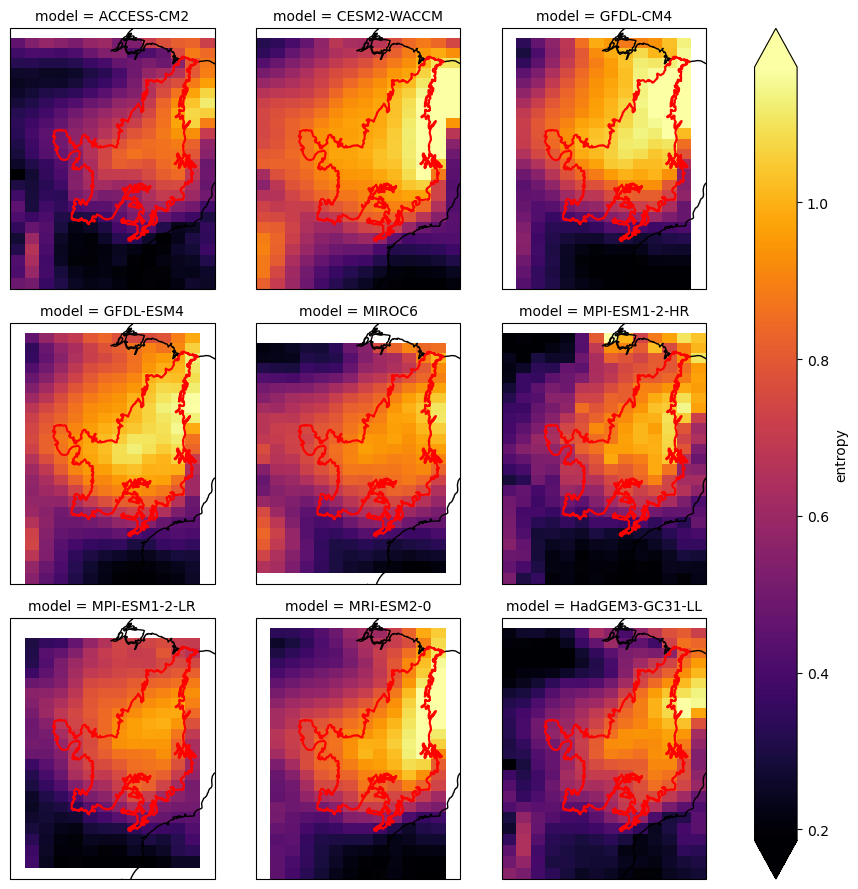

In [775]:
p = ds_historical_ent.sel(model=bests).entropy.mean('year').plot(transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": proj_plot},
                             col='model', col_wrap=3, robust=True, cmap='inferno')

for ax in p.axes.flat:
    ax.coastlines()
    shp_cerrado.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='red')

## tas

In [1]:
dset_dict = ensemble_models('historical', bests, var='tas')
ds_regridss = regrid_models(dset_dict, 1981, 2010, list(dset_dict)[-1])
ds_regridss['tas'] = ds_regridss['tas']-273.15
ds_historical_all = ds_regridss.drop(['height', 'dcpp_init_year']).load()
#ds_historical_all.to_netcdf(r'Data\CMIP6\tas_historical_bests_models.nc')


NameError: name 'ensemble_models' is not defined

In [55]:
dset_dict = ensemble_models('ssp585', bests, var='tas')
ds_regridss = regrid_models(dset_dict, 2071, 2100, list(dset_dict)[-1])
ds_regridss['tas'] = ds_regridss['tas']-273.15
ds_ssp585_all = ds_regridss.drop(['height', 'dcpp_init_year']).load()
ds_ssp585_all.to_netcdf(r'Data\CMIP6\tas_ssp585_bests_models.nc')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [57]:
dset_dict245 = ensemble_models('ssp245', bests, var='tas')
ds_regridss = regrid_models(dset_dict245, 2071, 2100, list(dset_dict245)[-1])
ds_regridss['tas'] = ds_regridss['tas']-273.15
ds_ssp245_all = ds_regridss.drop(['height', 'dcpp_init_year']).load()
ds_ssp245_all.to_netcdf(r'Data\CMIP6\tas_ssp245_bests_models.nc')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## tasmin

In [164]:
dset_dict = ensemble_models('historical', bests, var='tasmin')
print(len(dset_dict))
ds_regridss = regrid_models(dset_dict, 1981, 2010, list(dset_dict)[-1])
ds_regridss['tasmin'] = ds_regridss['tasmin']-273.15
ds_historical_all = ds_regridss.drop(['height', 'dcpp_init_year']).load()
ds_historical_all.to_netcdf(r'Data\CMIP6\tasmin_historical_bests_models.nc')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [173]:
dset_dict = ensemble_models('ssp585', bests, var='tasmin')
dset_dict.pop('ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn')
ds_regridss = regrid_models(dset_dict, 2071, 2100, list(dset_dict)[-1])
ds_regridss['tasmin'] = ds_regridss['tasmin']-273.15
ds_ssp585_all = ds_regridss.drop(['height', 'dcpp_init_year']).load()
ds_ssp585_all.to_netcdf(r'Data\CMIP6\tasmin_ssp585_bests_models.nc')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [175]:
dset_dict245 = ensemble_models('ssp245', bests, var='tasmin')
ds_regridss = regrid_models(dset_dict245, 2071, 2100, list(dset_dict245)[-1])
ds_regridss['tasmin'] = ds_regridss['tasmin']-273.15
ds_ssp245_all = ds_regridss.drop(['height', 'dcpp_init_year']).load()
ds_ssp245_all.to_netcdf(r'Data\CMIP6\tasmin_ssp245_bests_models.nc')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## tasmax

In [182]:
dset_dict = ensemble_models('historical', bests, var='tasmax')
ds_regridss = regrid_models(dset_dict, 1981, 2010, list(dset_dict)[-1])
ds_regridss['tasmax'] = ds_regridss['tasmax']-273.15
ds_historical_all = ds_regridss.drop(['height', 'dcpp_init_year']).load()
ds_historical_all.to_netcdf(r'Data\CMIP6\tasmax_historical_bests_models.nc')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [184]:
dset_dict = ensemble_models('ssp585', bests, var='tasmax')
dset_dict.pop('ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn')
ds_regridss = regrid_models(dset_dict, 2071, 2100, list(dset_dict)[-1])
ds_regridss['tasmax'] = ds_regridss['tasmax']-273.15
ds_ssp585_all = ds_regridss.drop(['height', 'dcpp_init_year']).load()
ds_ssp585_all.to_netcdf(r'Data\CMIP6\tasmax_ssp585_bests_models.nc')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [185]:
dset_dict245 = ensemble_models('ssp245', bests, var='tasmax')
ds_regridss = regrid_models(dset_dict245, 2071, 2100, list(dset_dict245)[-1])
ds_regridss['tasmax'] = ds_regridss['tasmax']-273.15
ds_ssp245_all = ds_regridss.drop(['height', 'dcpp_init_year']).load()
ds_ssp245_all.to_netcdf(r'Data\CMIP6\tasmax_ssp245_bests_models.nc')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## RH

In [191]:
dset_dict = ensemble_models('historical', bests, var='hurs')
ds_regridss = regrid_models(dset_dict, 1981, 2010, list(dset_dict)[-1])
ds_historical_all = ds_regridss.drop(['height', 'dcpp_init_year']).load()
ds_historical_all.to_netcdf(r'Data\CMIP6\hurs_historical_bests_models.nc')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [192]:
dset_dict = ensemble_models('ssp585', bests, var='hurs')
ds_regridss = regrid_models(dset_dict, 2071, 2100, list(dset_dict)[-1])
ds_ssp585_all = ds_regridss.drop(['height', 'dcpp_init_year']).load()
ds_ssp585_all.to_netcdf(r'Data\CMIP6\hurs_ssp585_bests_models.nc')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [193]:
dset_dict245 = ensemble_models('ssp245', bests, var='hurs')
ds_regridss = regrid_models(dset_dict245, 2071, 2100, list(dset_dict245)[-1])
ds_ssp245_all = ds_regridss.drop(['height', 'dcpp_init_year']).load()
ds_ssp245_all.to_netcdf(r'Data\CMIP6\hurs_ssp245_bests_models.nc')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


# VPD

In [16]:
#open tas and RH datasets
ds_historical_tas = xr.open_dataset(r'Data\CMIP6\tas_historical_bests_models.nc')
ds_ssp585_tas = xr.open_dataset(r'Data\CMIP6\tas_ssp585_bests_models.nc')
ds_ssp245_tas = xr.open_dataset(r'Data\CMIP6\tas_ssp245_bests_models.nc')
#tas min
ds_historical_tasmin = xr.open_dataset(r'Data\CMIP6\tasmin_historical_bests_models.nc')
ds_ssp585_tasmin = xr.open_dataset(r'Data\CMIP6\tasmin_ssp585_bests_models.nc')
ds_ssp245_tasmin = xr.open_dataset(r'Data\CMIP6\tasmin_ssp245_bests_models.nc')
#tasmax
ds_historical_tasmax = xr.open_dataset(r'Data\CMIP6\tasmax_historical_bests_models.nc')
ds_ssp585_tasmax = xr.open_dataset(r'Data\CMIP6\tasmax_ssp585_bests_models.nc')
ds_ssp245_tasmax = xr.open_dataset(r'Data\CMIP6\tasmax_ssp245_bests_models.nc')


ds_historical_hurs = xr.open_dataset(r'Data\CMIP6\hurs_historical_bests_models.nc')
ds_ssp585_hurs = xr.open_dataset(r'Data\CMIP6\hurs_ssp585_bests_models.nc')
ds_ssp245_hurs = xr.open_dataset(r'Data\CMIP6\hurs_ssp245_bests_models.nc')

In [43]:
#merge datasets for tas and RH
ds_historical_vpd = xr.merge([ds_historical_tas, ds_historical_tasmin,ds_historical_tasmax, ds_historical_hurs])
ds_ssp585_vpd = xr.merge([ds_ssp585_tas, ds_ssp585_tasmin, ds_ssp585_tasmax, ds_ssp585_hurs])
ds_ssp245_vpd = xr.merge([ds_ssp245_tas, ds_ssp245_tasmin, ds_ssp245_tasmax, ds_ssp245_hurs])

In [44]:
def vpd(temp, rh):
    return 0.6108 * np.exp((17.27 * temp) / (temp + 237.3)) * (1 - rh/100)

ds_historical_vpd['vpd'] = vpd(ds_historical_vpd['tas'], ds_historical_vpd['hurs'])
ds_ssp585_vpd['vpd'] = vpd(ds_ssp585_vpd['tas'], ds_ssp585_vpd['hurs'])
ds_ssp245_vpd['vpd'] = vpd(ds_ssp245_vpd['tas'], ds_ssp245_vpd['hurs'])

In [35]:
#save
#ds_historical.to_netcdf(r'Data\CMIP6\vpd_historical_bests_models.nc')
#ds_ssp585.to_netcdf(r'Data\CMIP6\vpd_ssp585_bests_models.nc')
#ds_ssp245.to_netcdf(r'Data\CMIP6\vpd_ssp245_bests_models.nc')

In [36]:
#create a mask for the regions 
mask = cerrado_mask.mask(ds_historical_vpd_clim, lon_name='lon', lat_name='lat')
ds_historical_vpd_clim['mask'] = mask

NameError: name 'cerrado_mask' is not defined

In [37]:
#to dataframe and plot kde for each variable
ds_historical.mean(dim='model').mean(dim='time').to_dataframe().reset_index()

lat       lon         tas      tasmin      tasmax       hurs  vpd  \
0   -29.375  293.4375  -47.069443  -59.166378  -50.769791  48.683064  inf   
1   -29.375  295.3125  -44.816689  -56.967312  -48.862251  45.950840  inf   
2   -29.375  297.1875  -44.444988  -56.432850  -48.737499  47.113899  inf   
3   -29.375  299.0625  -44.531509  -56.326183  -49.161289  50.583355  inf   
4   -29.375  300.9375  -44.872375  -56.547745  -49.701790  54.287067  inf   
..      ...       ...         ...         ...         ...        ...  ...   
411   1.875  314.0625 -206.568222 -198.308136 -198.181473  17.733227  inf   
412   1.875  315.9375 -206.564590 -198.305984 -198.177979  17.637096  inf   
413   1.875  317.8125 -206.568359 -198.311935 -198.181442  17.588747  inf   
414   1.875  319.6875 -206.576675 -198.322540 -198.189545  17.558321  inf   
415   1.875  321.5625 -206.578674 -198.325806 -198.190689  17.496819  inf   

         vpd2  
0    0.891024  
1    1.143170  
2    1.118604  
3    0.968352  
4    0.792619  
..        ...  
411  0.698805  
412  0.713636  
413  0.720326  
414  0.723590  
415  0.732748  

[416 rows x 8 columns]

# plots

## pr

In [6]:
#ds_historical_all.to_netcdf('Data\CMIP6\pr_historical_all_models.nc')
ds_historical_all = xr.open_dataset('Data\CMIP6\pr_historical_bests_models.nc')
ds_ssp585_all = xr.open_dataset('Data\CMIP6\pr_ssp585_bests_models.nc')
ds_ssp245_all = xr.open_dataset('Data\CMIP6\pr_ssp245_bests_models.nc')

ds_historical_ent = xr.open_dataset('Data\CMIP6\ent_historical_bests_models.nc')
ds_ssp585_all_ent = xr.open_dataset('Data\CMIP6\ent_ssp585_bests_models.nc')
ds_ssp245_all_ent = xr.open_dataset('Data\CMIP6\ent_ssp245_bests_models.nc')

In [72]:
bests = ['ACCESS-CM2',
 'CESM2-WACCM',
 'GFDL-CM4',
 'GFDL-ESM4',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'HadGEM3-GC31-LL']

In [7]:
# set the climatologies
ds_historical_pr_clim = ds_historical_all.sel(model=bests).mean('time', keep_attrs=True).mean('model', keep_attrs=True)
ds_ssp585_all_pr_clim = ds_ssp585_all.sel(model=bests).mean('time').mean('model')
ds_ssp245_all_pr_clim = ds_ssp245_all.sel(model=bests).mean('time').mean('model')
ds_historical_pr_clim['pr'] = ds_historical_pr_clim.pr * 12
ds_ssp245_all_pr_clim['pr'] = ds_ssp245_all_pr_clim.pr * 12
ds_ssp585_all_pr_clim['pr'] = ds_ssp585_all_pr_clim.pr * 12
ds_ssp245_pr_anomaly = (ds_ssp245_all_pr_clim - ds_historical_pr_clim)
ds_ssp585_pr_anomaly = (ds_ssp585_all_pr_clim - ds_historical_pr_clim)

#set units for the ds
ds_historical_pr_clim.pr.attrs['units'] = 'mm/year'
ds_ssp245_all_pr_clim.pr.attrs['units'] = 'mm/year'
ds_ssp585_all_pr_clim.pr.attrs['units'] = 'mm/year'
ds_ssp245_pr_anomaly.pr.attrs['units'] = 'mm/year'
ds_ssp585_pr_anomaly.pr.attrs['units'] = 'mm/year'

# set entropy climatologies
ds_historical_ent_clim = ds_historical_ent.sel(model=bests).mean('year').mean('model')
ds_ssp585_all_ent_clim = ds_ssp585_all_ent.sel(model=bests).mean('year').mean('model')
ds_ssp245_all_ent_clim = ds_ssp245_all_ent.sel(model=bests).mean('year').mean('model')
ds_ssp585_ent_anomaly = (ds_ssp585_all_ent_clim - ds_historical_ent_clim)
ds_ssp245_ent_anomaly = (ds_ssp245_all_ent_clim - ds_historical_ent_clim)

#set variable name
ds_historical_pr_clim.pr.attrs['long_name'] = 'Mean Annual Precipitation'
ds_ssp245_pr_anomaly.pr.attrs['long_name'] = 'Annual Precipitation Anomaly'
ds_ssp245_pr_anomaly.pr.attrs['long_name'] = 'Annual Precipitation Anomaly'

ds_historical_ent_clim.entropy.attrs['long_name'] = 'Relative Entropy'
ds_ssp245_ent_anomaly.entropy.attrs['long_name'] = 'Relative Entropy Anomaly'
ds_ssp585_ent_anomaly.entropy.attrs['long_name'] = 'Relative Entropy Anomaly'

In [21]:
ds_ssp245_pr_ratio = (ds_ssp245_pr_anomaly.pr/ds_historical_pr_clim.pr)*100
ds_ssp585_pr_ratio = (ds_ssp585_pr_anomaly.pr/ds_historical_pr_clim.pr)*100

ds_ssp245_ent_ratio = (ds_ssp245_ent_anomaly.entropy / ds_historical_ent_clim.entropy )*100
ds_ssp585_ent_ratio = (ds_ssp585_ent_anomaly.entropy / ds_historical_ent_clim.entropy )*100

Text(0.5, 1.0, 'ratio - SSP5-8.5 2071-2100')

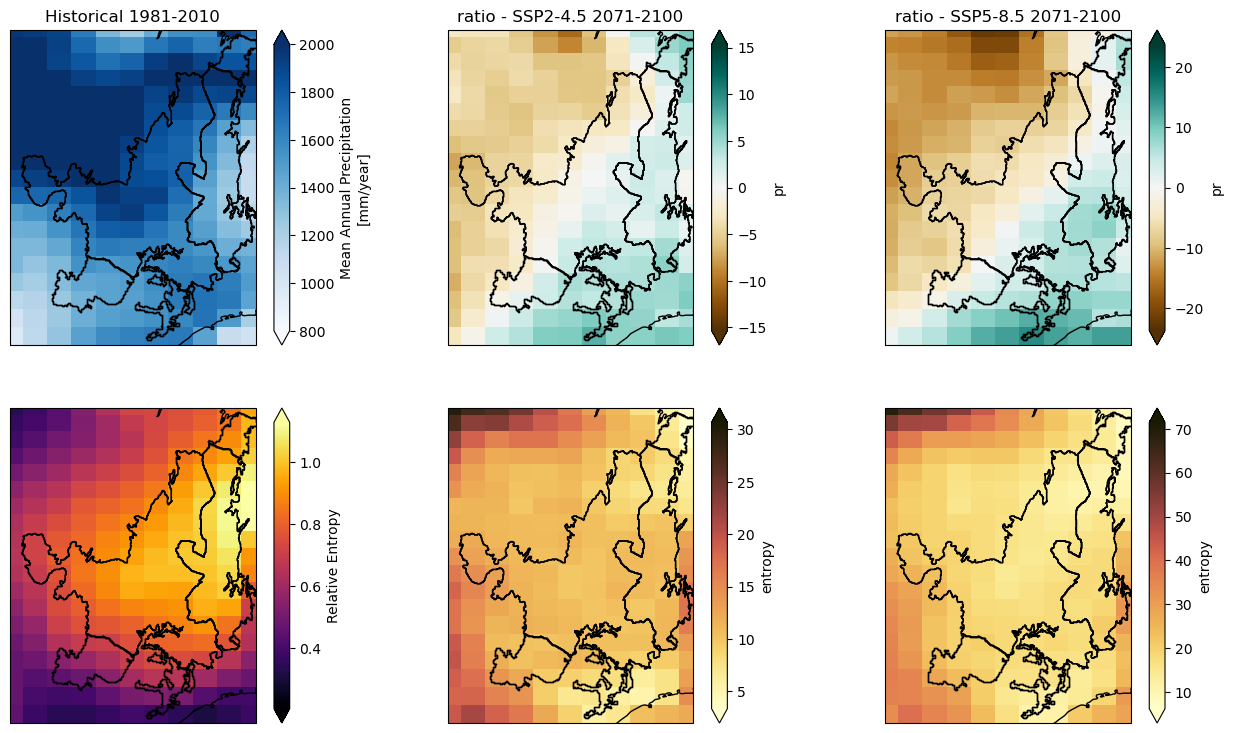

In [22]:
proj_plot = ccrs.Mercator()
fig, ax = plt.subplots(2, 3, figsize=(16, 9), subplot_kw={'projection': proj_plot})

ds_historical_pr_clim.pr.plot(ax=ax[0][0], transform=ccrs.PlateCarree(), vmin=800, vmax=2000, cmap='Blues')
ds_ssp245_pr_ratio.plot(ax=ax[0][1], transform=ccrs.PlateCarree(),  cmap='BrBG', robust=True)
ds_ssp585_pr_ratio.plot(ax=ax[0][2], transform=ccrs.PlateCarree(),  cmap='BrBG', robust=True)

ds_historical_ent_clim.entropy.plot(ax=ax[1][0], transform=ccrs.PlateCarree(), cmap='inferno', robust=True)
ds_ssp245_ent_ratio.plot(ax=ax[1][1], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', robust=True)
ds_ssp585_ent_ratio.plot(ax=ax[1][2], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', robust=True)

for i in ax.flat:    
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    i.coastlines()
    #set axis extend
    i.set_extent([-61, -42, -25, -2], crs=ccrs.PlateCarree())

#set axis titles
ax[0][0].set_title('Historical 1981-2010')
ax[0][1].set_title('ratio - SSP2-4.5 2071-2100')
ax[0][2].set_title('ratio - SSP5-8.5 2071-2100') 


Text(0.5, 1.0, 'Anomaly - SSP5-8.5 2071-2100')

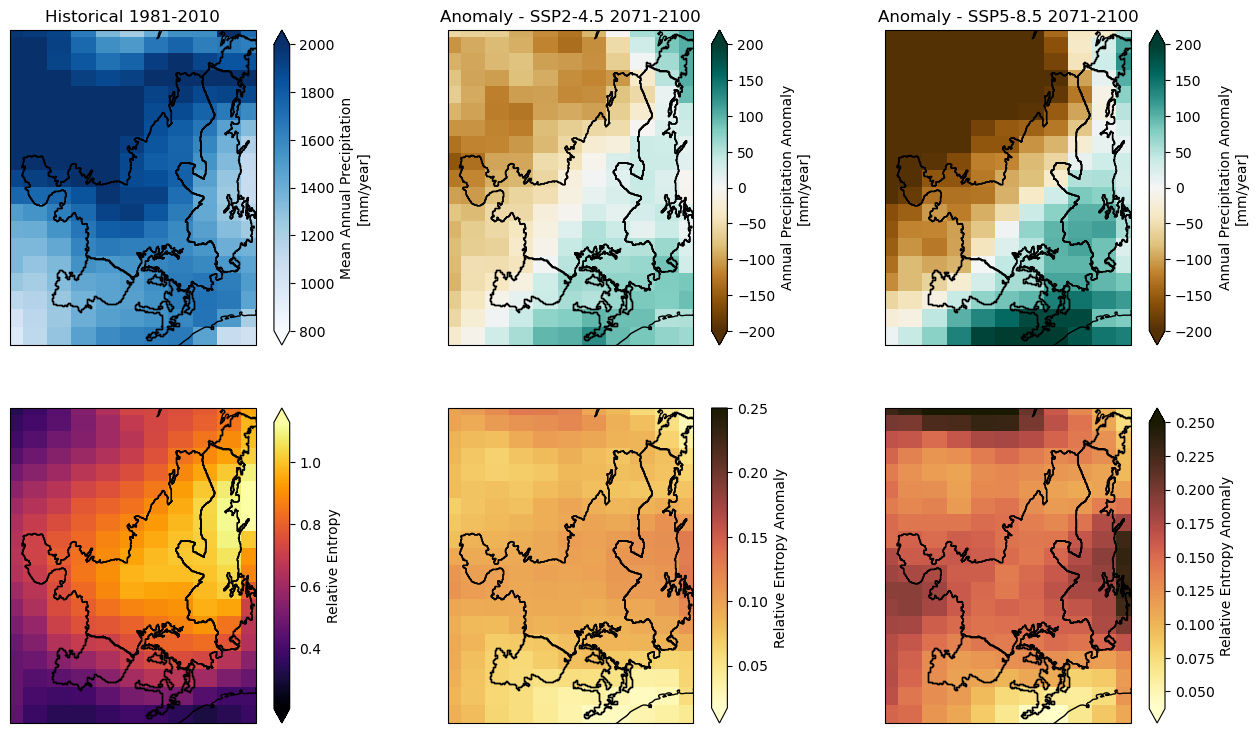

In [8]:
proj_plot = ccrs.Mercator()
fig, ax = plt.subplots(2, 3, figsize=(16, 9), subplot_kw={'projection': proj_plot})

ds_historical_pr_clim.pr.plot(ax=ax[0][0], transform=ccrs.PlateCarree(), vmin=800, vmax=2000, cmap='Blues')
ds_ssp245_pr_anomaly.pr.plot(ax=ax[0][1], transform=ccrs.PlateCarree(), vmin=-200, vmax=200, cmap='BrBG')
ds_ssp585_pr_anomaly.pr.plot(ax=ax[0][2], transform=ccrs.PlateCarree(), vmin=-200, vmax=200, cmap='BrBG')

ds_historical_ent_clim.entropy.plot(ax=ax[1][0], transform=ccrs.PlateCarree(), cmap='inferno', robust=True)
ds_ssp245_ent_anomaly.entropy.plot(ax=ax[1][1], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', robust=True, vmax=0.25)
ds_ssp585_ent_anomaly.entropy.plot(ax=ax[1][2], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', robust=True, vmax=0.25)

for i in ax.flat:    
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    i.coastlines()
    #set axis extend
    i.set_extent([-61, -42, -25, -2], crs=ccrs.PlateCarree())

#set axis titles
ax[0][0].set_title('Historical 1981-2010')
ax[0][1].set_title('Anomaly - SSP2-4.5 2071-2100')
ax[0][2].set_title('Anomaly - SSP5-8.5 2071-2100') 


### season

In [69]:
#calculate the season mean
ds_historical_pr_clim_season = ds_historical_all.sel(model=bests).groupby('time.season').mean('time', keep_attrs=True).mean('model', keep_attrs=True)
ds_ssp585_all_pr_clim_season = ds_ssp585_all.sel(model=bests).groupby('time.season').mean('time').mean('model')
ds_ssp245_all_pr_clim_season = ds_ssp245_all.sel(model=bests).groupby('time.season').mean('time').mean('model')

#anomalies
ds_ssp245_pr_anomaly_season = (ds_ssp245_all_pr_clim_season - ds_historical_pr_clim_season)
ds_ssp585_pr_anomaly_season = (ds_ssp585_all_pr_clim_season - ds_historical_pr_clim_season)

Text(0.5, 1.0, 'Anomaly - SSP5-8.5 2081-2100')

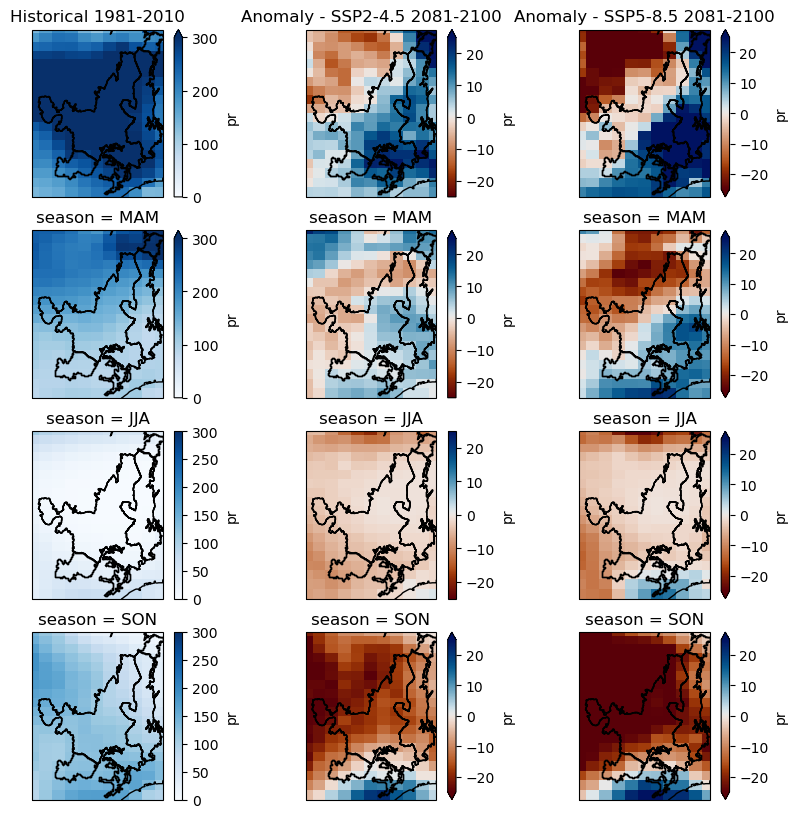

In [70]:
#plot the historical and anomalies for each season

seasons = ['DJF', 'MAM', 'JJA', 'SON']
fig, ax = plt.subplots(4, 3, subplot_kw={'projection': proj_plot}, figsize=(10,10))



for i, sea in enumerate(seasons):
    ds_historical_pr_clim_season.sel(season=sea).pr.plot(ax=ax[i][0], transform=ccrs.PlateCarree(), cmap='Blues', vmax=300, vmin=0)
    ds_ssp245_pr_anomaly_season.sel(season= sea).pr.plot(ax=ax[i][1], transform=ccrs.PlateCarree(), cmap='cmc.vik_r',vmax=25, vmin=-25)
    ds_ssp585_pr_anomaly_season.sel(season= sea).pr.plot(ax=ax[i][2], transform=ccrs.PlateCarree(), cmap='cmc.vik_r',vmax=25, vmin=-25)

for i in ax.flat:    
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    i.coastlines()
    #set axis extend
    i.set_extent([-61, -42, -25, -2], crs=ccrs.PlateCarree())

ax[0][0].set_title('Historical 1981-2010')
ax[0][1].set_title('Anomaly - SSP2-4.5 2081-2100')
ax[0][2].set_title('Anomaly - SSP5-8.5 2081-2100') 

### DSL

In [12]:
ds_historical_dsl_clim = (ds_historical_all.pr < 100).groupby('time.year').sum().mean('year').mean('model')
ds_ssp585_dsl_clim = (ds_ssp585_all.pr < 100).groupby('time.year').sum().mean('year').mean('model')
ds_ssp245_dsl_clim = (ds_ssp245_all.pr < 100).groupby('time.year').sum().mean('year').mean('model')

ds_ssp585_dsl_anomaly = (ds_ssp585_dsl_clim - ds_historical_dsl_clim)
ds_ssp245_dsl_anomaly = (ds_ssp245_dsl_clim - ds_historical_dsl_clim)

In [13]:
# CHANGE VARIABLE NAME
ds_historical_dsl_clim.attrs['long_name'] = 'Dry Season Length'
ds_ssp245_dsl_anomaly.attrs['long_name'] = 'Dry Season Length Anomaly'
ds_ssp585_dsl_anomaly.attrs['long_name'] = 'Dry Season Length Anomaly'

Text(0.5, 1.0, 'Anomaly - SSP5-8.5 2081-2100')

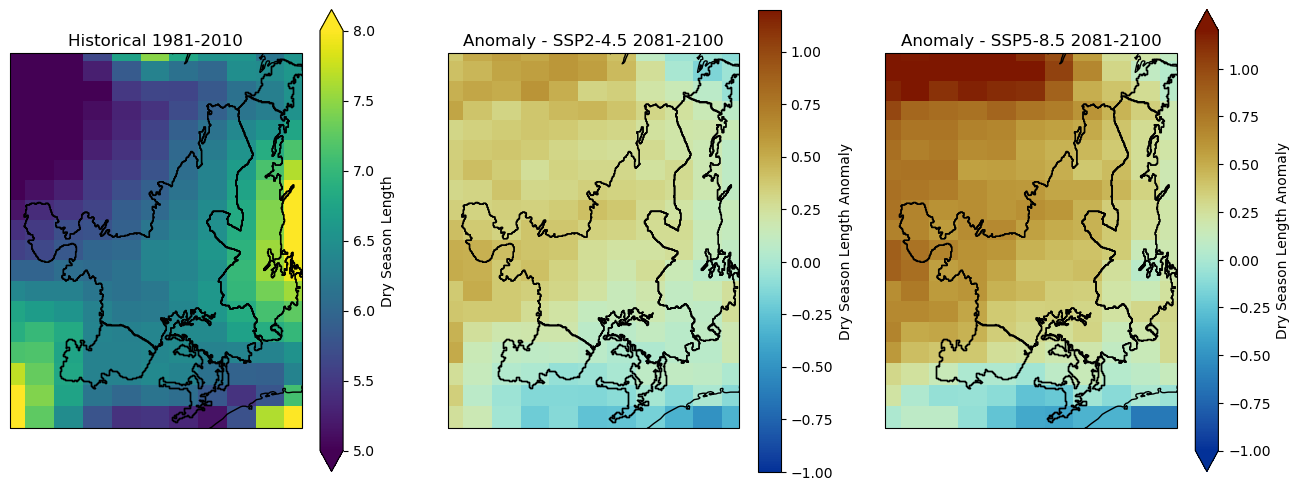

In [14]:
#plot the historical and anomalies
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': proj_plot}, figsize=(16,6))
ds_historical_dsl_clim.plot(ax=ax[0], transform=ccrs.PlateCarree(), vmax=8, vmin=5, cmap='viridis')
ds_ssp245_dsl_anomaly.plot(ax=ax[1], transform=ccrs.PlateCarree(),vmin=-1, vmax=1.2, cmap='cmc.roma_r')
ds_ssp585_dsl_anomaly.plot(ax=ax[2], transform=ccrs.PlateCarree(),vmin=-1, vmax=1.2, cmap='cmc.roma_r')

for i in ax.flat:
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    i.coastlines()
    #set axis extend
    i.set_extent([-61, -42, -25, -2], crs=ccrs.PlateCarree())


#set axis titles
ax[0].set_title('Historical 1981-2010')
ax[1].set_title('Anomaly - SSP2-4.5 2081-2100')
ax[2].set_title('Anomaly - SSP5-8.5 2081-2100')    

## temp

In [9]:
ds_historical_tas = xr.open_dataset(r'Data\CMIP6\tas_historical_bests_models.nc')
ds_ssp585_tas = xr.open_dataset(r'Data\CMIP6\tas_ssp585_bests_models.nc')
ds_ssp245_tas = xr.open_dataset(r'Data\CMIP6\tas_ssp245_bests_models.nc')
#tas min
ds_historical_tasmin = xr.open_dataset(r'Data\CMIP6\tasmin_historical_bests_models.nc')
ds_ssp585_tasmin = xr.open_dataset(r'Data\CMIP6\tasmin_ssp585_bests_models.nc')
ds_ssp245_tasmin = xr.open_dataset(r'Data\CMIP6\tasmin_ssp245_bests_models.nc')
#tasmax
ds_historical_tasmax = xr.open_dataset(r'Data\CMIP6\tasmax_historical_bests_models.nc')
ds_ssp585_tasmax = xr.open_dataset(r'Data\CMIP6\tasmax_ssp585_bests_models.nc')
ds_ssp245_tasmax = xr.open_dataset(r'Data\CMIP6\tasmax_ssp245_bests_models.nc')

In [10]:
# set the climatologies
ds_historical_tas_clim = ds_historical_tas.mean('time', keep_attrs=True).mean('model', keep_attrs=True)
ds_ssp585_tas_clim = ds_ssp585_tas.mean('time').mean('model')
ds_ssp245_tas_clim = ds_ssp245_tas.mean('time').mean('model')
ds_ssp245_tas_anomaly = (ds_ssp245_tas_clim - ds_historical_tas_clim)
ds_ssp585_tas_anomaly = (ds_ssp585_tas_clim - ds_historical_tas_clim)
#tasmin
ds_historical_tasmin_clim = ds_historical_tasmin.mean('time', keep_attrs=True).mean('model', keep_attrs=True)
ds_ssp585_tasmin_clim = ds_ssp585_tasmin.mean('time').mean('model')
ds_ssp245_tasmin_clim = ds_ssp245_tasmin.mean('time').mean('model')
ds_ssp245_tasmin_anomaly = (ds_ssp245_tasmin_clim - ds_historical_tasmin_clim)
ds_ssp585_tasmin_anomaly = (ds_ssp585_tasmin_clim - ds_historical_tasmin_clim)
#tasmax
ds_historical_tasmax_clim = ds_historical_tasmax.mean('time', keep_attrs=True).mean('model', keep_attrs=True)
ds_ssp585_tasmax_clim = ds_ssp585_tasmax.mean('time').mean('model')
ds_ssp245_tasmax_clim = ds_ssp245_tasmax.mean('time').mean('model')
ds_ssp245_tasmax_anomaly = (ds_ssp245_tasmax_clim - ds_historical_tasmax_clim)
ds_ssp585_tasmax_anomaly = (ds_ssp585_tasmax_clim - ds_historical_tasmax_clim)


In [11]:
#set units for ds as celcius
ds_historical_tas_clim.tas.attrs['units'] = '°C'
ds_ssp245_tas_anomaly.tas.attrs['units'] = '°C'
ds_ssp585_tas_anomaly.tas.attrs['units'] = '°C'
#tasmin
ds_historical_tasmin_clim.tasmin.attrs['units'] = '°C'
ds_ssp245_tasmin_anomaly.tasmin.attrs['units'] = '°C'
ds_ssp585_tasmin_anomaly.tasmin.attrs['units'] = '°C'
#tasmax
ds_historical_tasmax_clim.tasmax.attrs['units'] = '°C'
ds_ssp245_tasmax_anomaly.tasmax.attrs['units'] = '°C'
ds_ssp585_tasmax_anomaly.tasmax.attrs['units'] = '°C'




In [12]:
#set variable name
ds_historical_tas_clim.tas.attrs['long_name'] = 'Near-Surface Air Temperature ºC'
ds_ssp245_tas_anomaly.tas.attrs['long_name'] = 'Near-Surface Air Temperature Anomaly ºC'
ds_ssp585_tas_anomaly.tas.attrs['long_name'] = 'Near-Surface Air Temperature Anomaly ºC'
#tasmin
ds_historical_tasmin_clim.tasmin.attrs['long_name'] = 'Minimum Near-Surface Air Temperature ºC'
ds_ssp245_tasmin_anomaly.tasmin.attrs['long_name'] = 'Minimum Near-Surface Air Temperature Anomaly ºC'
ds_ssp585_tasmin_anomaly.tasmin.attrs['long_name'] = 'Minimum Near-Surface Air Temperature Anomaly ºC'
#tasmax
ds_historical_tasmax_clim.tasmax.attrs['long_name'] = 'Maximum Near-Surface Air Temperature ºC'
ds_ssp245_tasmax_anomaly.tasmax.attrs['long_name'] = 'Maximum Near-Surface Air Temperature Anomaly ºC'
ds_ssp585_tasmax_anomaly.tasmax.attrs['long_name'] = 'Maximum Near-Surface Air Temperature Anomaly ºC'



Text(0.5, 1.0, 'Anomaly - SSP5-8.5 2071-2100')

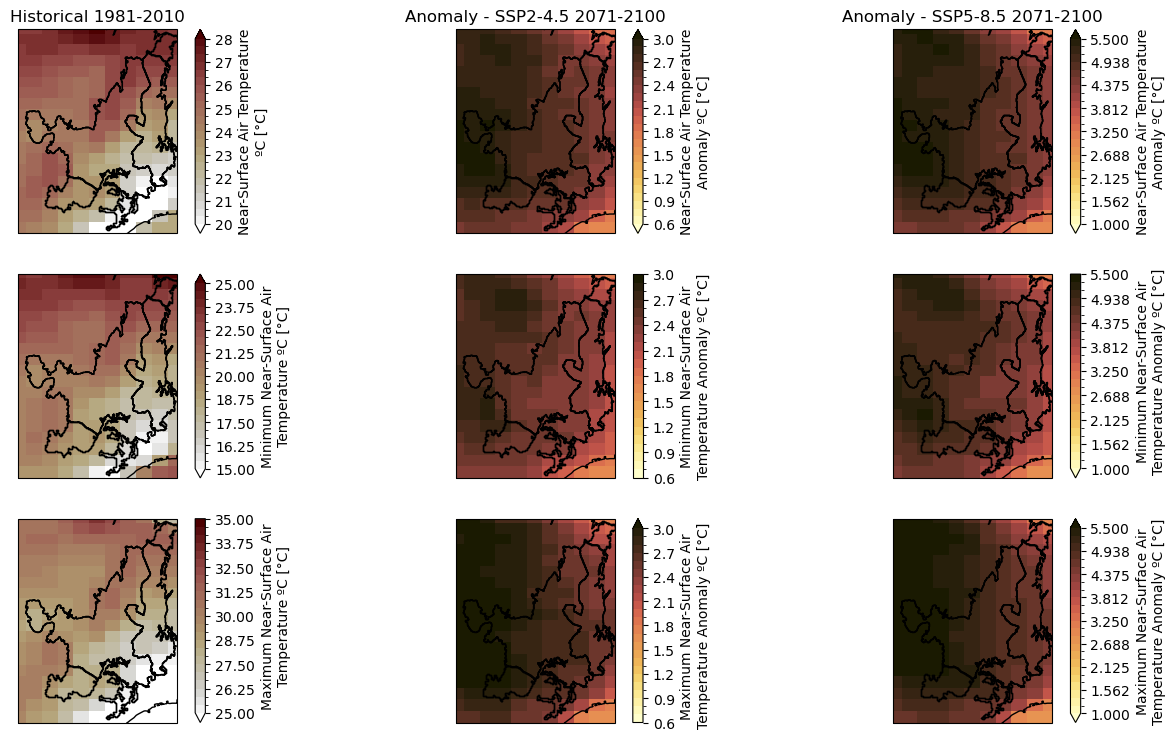

In [204]:
proj_plot = ccrs.Mercator()
fig, ax = plt.subplots(3, 3, figsize=(16, 9), subplot_kw={'projection': proj_plot})

ds_historical_tas_clim.tas.plot(ax=ax[0][0], transform=ccrs.PlateCarree(), vmax=28, vmin=20, cmap='cmc.bilbao', levels = 25)
ds_ssp245_tas_anomaly.tas.plot(ax=ax[0][1], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', levels = 25, vmax=3, vmin=0.6)
ds_ssp585_tas_anomaly.tas.plot(ax=ax[0][2], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', levels = 25, vmax=5.5, vmin=1)

ds_historical_tasmin_clim.tasmin.plot(ax=ax[1][0], transform=ccrs.PlateCarree(), vmax=25, vmin=15, cmap='cmc.bilbao', levels = 25)
ds_ssp245_tasmin_anomaly.tasmin.plot(ax=ax[1][1], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', levels = 25, vmax=3, vmin=0.6)
ds_ssp585_tasmin_anomaly.tasmin.plot(ax=ax[1][2], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', levels = 25, vmax=5.5, vmin=1)

ds_historical_tasmax_clim.tasmax.plot(ax=ax[2][0], transform=ccrs.PlateCarree(), vmax=35, vmin=25, cmap='cmc.bilbao', levels = 25)
ds_ssp245_tasmax_anomaly.tasmax.plot(ax=ax[2][1], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', levels = 25, vmax=3, vmin=0.6)
ds_ssp585_tasmax_anomaly.tasmax.plot(ax=ax[2][2], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', levels = 25, vmax=5.5, vmin=1)



for i in ax.flat:    
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    i.coastlines()
    #set axis extend
    i.set_extent([-61, -42, -25, -2], crs=ccrs.PlateCarree())

#set axis titles
ax[0][0].set_title('Historical 1981-2010')
ax[0][1].set_title('Anomaly - SSP2-4.5 2071-2100')
ax[0][2].set_title('Anomaly - SSP5-8.5 2071-2100') 


### season


In [246]:
#calculate the season mean for tas
ds_historical_tas_clim_season = ds_historical_tas.groupby('time.season').mean('time', keep_attrs=True).mean('model', keep_attrs=True)
ds_ssp245_tas_anomaly_season = ds_ssp245_tas.groupby('time.season').mean('time').mean('model')
ds_ssp585_tas_anomaly_season = ds_ssp585_tas.groupby('time.season').mean('time').mean('model')

#anomaly
ds_ssp245_tas_anomaly_season = (ds_ssp245_tas_anomaly_season - ds_historical_tas_clim_season)
ds_ssp585_tas_anomaly_season = (ds_ssp585_tas_anomaly_season - ds_historical_tas_clim_season)


Text(0.5, 1.0, 'Anomaly - SSP5-8.5 2081-2100')

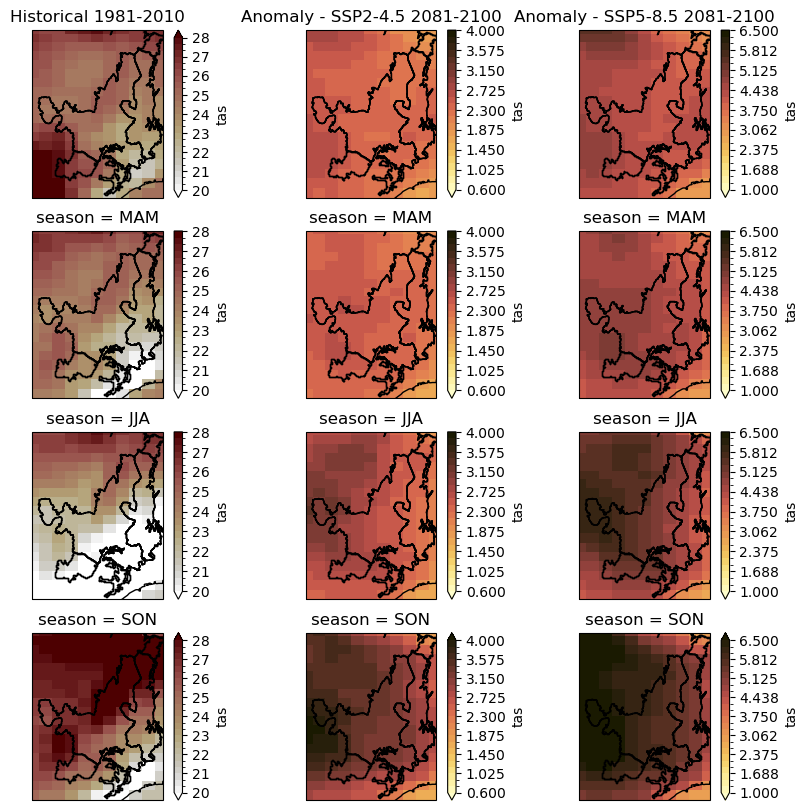

In [251]:
#plot the historical and anomalies for each season

seasons = ['DJF', 'MAM', 'JJA', 'SON']
fig, ax = plt.subplots(4, 3, subplot_kw={'projection': proj_plot}, figsize=(10,10))



for i, sea in enumerate(seasons):
    ds_historical_tas_clim_season.sel(season=sea).tas.plot(ax=ax[i][0], transform=ccrs.PlateCarree(), vmax=28, vmin=20, cmap='cmc.bilbao', levels = 25)
    ds_ssp245_tas_anomaly_season.sel(season=sea).tas.plot(ax=ax[i][1], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', levels = 25, vmax=4, vmin=0.6)
    ds_ssp585_tas_anomaly_season.sel(season=sea).tas.plot(ax=ax[i][2], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', levels = 25, vmax=6.5, vmin=1)
for i in ax.flat:    
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    i.coastlines()
    #set axis extend
    i.set_extent([-61, -42, -25, -2], crs=ccrs.PlateCarree())

ax[0][0].set_title('Historical 1981-2010')
ax[0][1].set_title('Anomaly - SSP2-4.5 2081-2100')
ax[0][2].set_title('Anomaly - SSP5-8.5 2081-2100') 

## RH 

In [13]:
ds_historical_hurs = xr.open_dataset(r'Data\CMIP6\hurs_historical_bests_models.nc')
ds_ssp245_hurs = xr.open_dataset(r'Data\CMIP6\hurs_ssp245_bests_models.nc')
ds_ssp585_hurs = xr.open_dataset(r'Data\CMIP6\hurs_ssp585_bests_models.nc')

In [14]:
# set the climatologies
ds_historical_hurs_clim = ds_historical_hurs.mean('time').mean('model')
ds_ssp245_hurs_clim = ds_ssp245_hurs.mean('time').mean('model')
ds_ssp585_hurs_clim = ds_ssp585_hurs.mean('time').mean('model')
# set the anomalies
ds_ssp245_hurs_anomaly = (ds_ssp245_hurs_clim - ds_historical_hurs_clim)
ds_ssp585_hurs_anomaly = (ds_ssp585_hurs_clim - ds_historical_hurs_clim)


In [15]:
#set variable name
ds_historical_hurs_clim.hurs.attrs['long_name'] = 'Near-Surface Relative Humidity %'
ds_ssp245_hurs_anomaly.hurs.attrs['long_name'] = 'Near-Surface Relative Humidity Anomaly %'
ds_ssp585_hurs_anomaly.hurs.attrs['long_name'] = 'Near-Surface Relative Humidity Anomaly %'

Text(0.5, 1.0, 'Anomaly - SSP5-8.5 2071-2100')

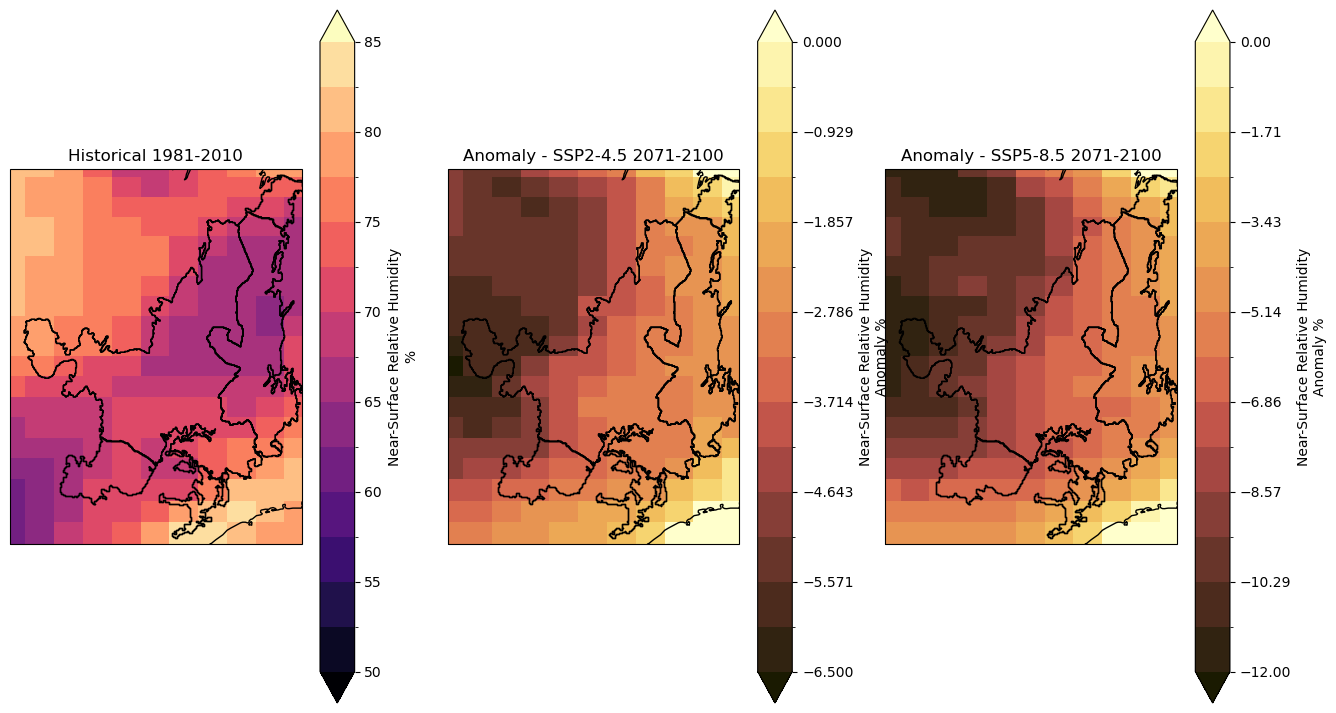

In [243]:
proj_plot = ccrs.Mercator()
fig, ax = plt.subplots(1, 3, figsize=(16, 9), subplot_kw={'projection': proj_plot})

ds_historical_hurs_clim.hurs.plot(ax=ax[0], transform=ccrs.PlateCarree(),  vmax=85, vmin=50, cmap='magma', levels = 15)
ds_ssp245_hurs_anomaly.hurs.plot(ax=ax[1], transform=ccrs.PlateCarree(), levels = 15 , cmap='cmc.lajolla_r',  vmax=0, vmin=-6.5)
ds_ssp585_hurs_anomaly.hurs.plot(ax=ax[2], transform=ccrs.PlateCarree(), levels = 15,  cmap='cmc.lajolla_r',  vmax=0, vmin=-12)



for i in ax.flat:    
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    i.coastlines()
    #set axis extend
    i.set_extent([-61, -42, -25, -2], crs=ccrs.PlateCarree())

#set axis titles
ax[0].set_title('Historical 1981-2010')
ax[1].set_title('Anomaly - SSP2-4.5 2071-2100')
ax[2].set_title('Anomaly - SSP5-8.5 2071-2100') 


### season

In [250]:
#calculate the season mean for hurs
ds_historical_hurs_clim_season = ds_historical_hurs.groupby('time.season').mean('time', keep_attrs=True).mean('model', keep_attrs=True)
ds_ssp245_hurs_anomaly_season = ds_ssp245_hurs.groupby('time.season').mean('time').mean('model')
ds_ssp585_hurs_anomaly_season = ds_ssp585_hurs.groupby('time.season').mean('time').mean('model')

#anomaly
ds_ssp245_hurs_anomaly_season = (ds_ssp245_hurs_anomaly_season - ds_historical_hurs_clim_season)
ds_ssp585_hurs_anomaly_season = (ds_ssp585_hurs_anomaly_season - ds_historical_hurs_clim_season)

Text(0.5, 1.0, 'Anomaly - SSP5-8.5 2081-2100')

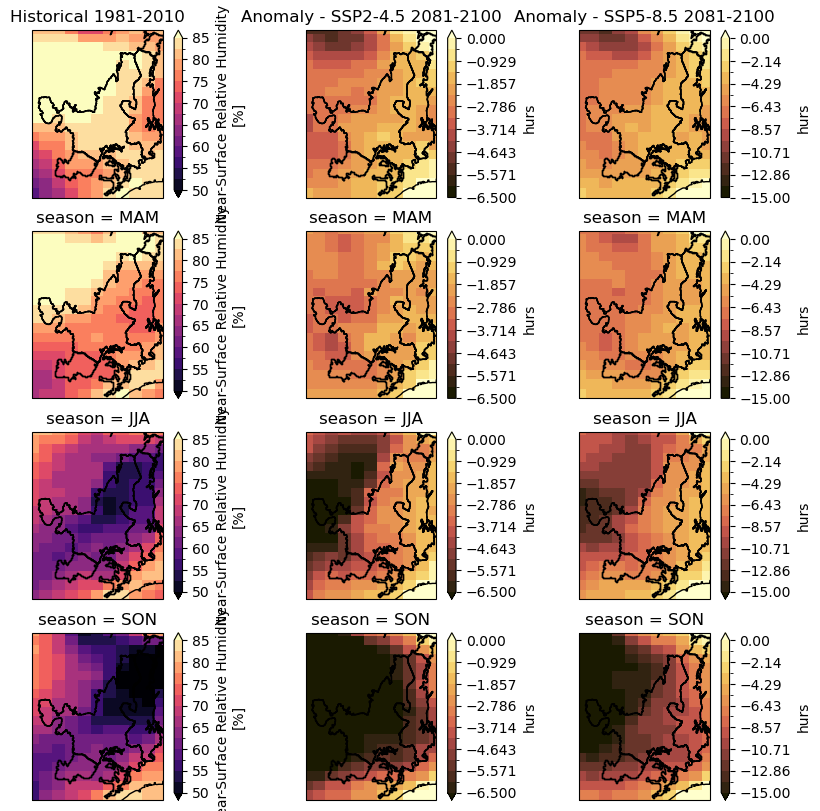

In [252]:
#plot the historical and anomalies for each season

seasons = ['DJF', 'MAM', 'JJA', 'SON']
fig, ax = plt.subplots(4, 3, subplot_kw={'projection': proj_plot}, figsize=(10,10))



for i, sea in enumerate(seasons):
    ds_historical_hurs_clim_season.sel(season=sea).hurs.plot(ax=ax[i][0], transform=ccrs.PlateCarree(), cmap='magma', levels = 15, vmax=85, vmin=50)
    ds_ssp245_hurs_anomaly_season.sel(season=sea).hurs.plot(ax=ax[i][1], transform=ccrs.PlateCarree(), cmap='cmc.lajolla_r', levels = 15, vmax=0, vmin=-6.5)
    ds_ssp585_hurs_anomaly_season.sel(season=sea).hurs.plot(ax=ax[i][2], transform=ccrs.PlateCarree(), cmap='cmc.lajolla_r', levels = 15, vmax=0, vmin=-15)

for i in ax.flat:    
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    i.coastlines()
    #set axis extend
    i.set_extent([-61, -42, -25, -2], crs=ccrs.PlateCarree())

ax[0][0].set_title('Historical 1981-2010')
ax[0][1].set_title('Anomaly - SSP2-4.5 2081-2100')
ax[0][2].set_title('Anomaly - SSP5-8.5 2081-2100') 

## VPD

In [10]:
ds_historical_vpd = xr.open_dataset(r'Data\CMIP6\vpd_historical_bests_models.nc')
ds_ssp245_vpd = xr.open_dataset(r'Data\CMIP6\vpd_ssp245_bests_models.nc')
ds_ssp585_vpd = xr.open_dataset(r'Data\CMIP6\vpd_ssp585_bests_models.nc')

In [46]:
#set climatologies
ds_historical_vpd_clim = ds_historical_vpd.mean(dim='time').mean(dim='model')
ds_ssp585_vpd_clim = ds_ssp585_vpd.mean(dim='time').mean(dim='model')
ds_ssp245_vpd_clim = ds_ssp245_vpd.mean(dim='time').mean(dim='model')

#set anomalies
ds_ssp585_vpd_anomaly = ds_ssp585_vpd_clim - ds_historical_vpd_clim
ds_ssp245_vpd_anomaly = ds_ssp245_vpd_clim - ds_historical_vpd_clim



Text(0.5, 1.0, 'Anomaly - SSP5-8.5 2071-2100')

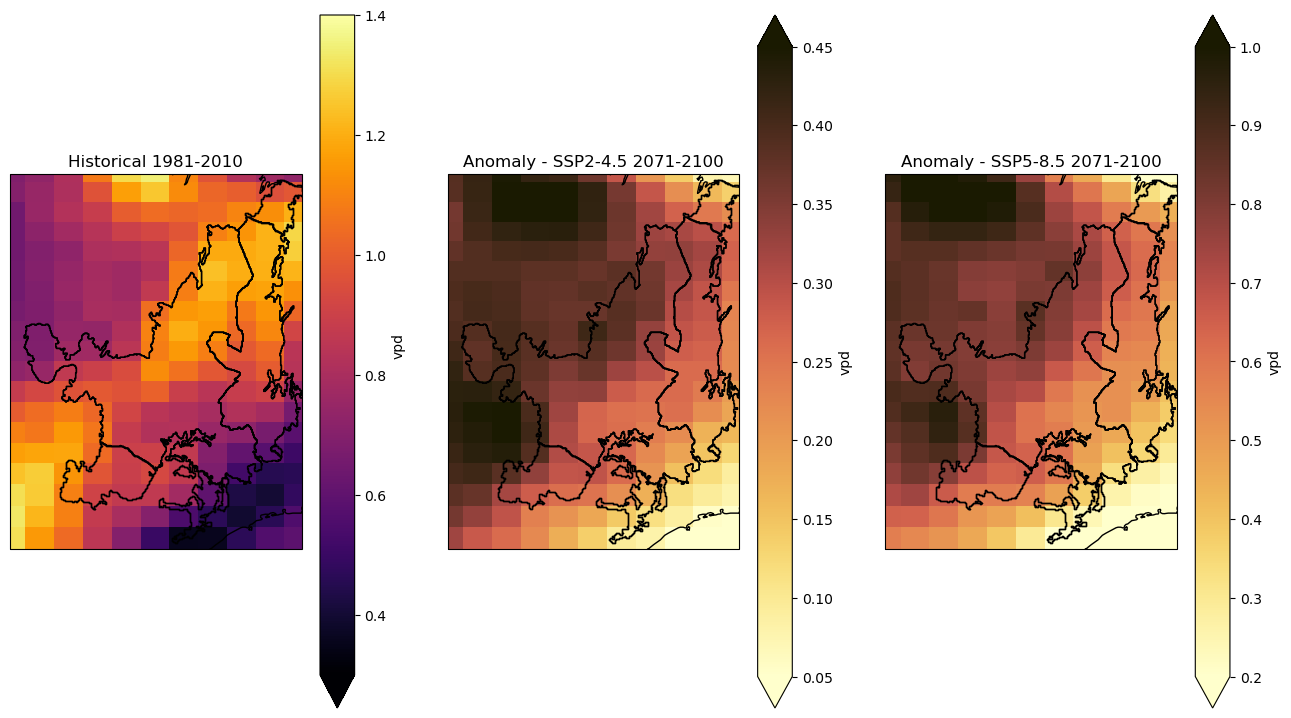

In [52]:


proj_plot = ccrs.Mercator()
fig, ax = plt.subplots(1, 3, figsize=(16, 9), subplot_kw={'projection': proj_plot})

#plot climatologies
ds_historical_vpd_clim['vpd'].plot(ax=ax[0], transform=ccrs.PlateCarree(), cmap='inferno', vmax=1.4, vmin=0.3)
ds_ssp245_vpd_anomaly['vpd'].plot(ax=ax[1], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', vmax=0.45, vmin=0.05)
ds_ssp585_vpd_anomaly['vpd'].plot(ax=ax[2], transform=ccrs.PlateCarree(), cmap='cmc.lajolla',  vmax=1, vmin=0.2)


for i in ax.flat:    
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    i.coastlines()
    #set axis extend
    i.set_extent([-61, -42, -25, -2], crs=ccrs.PlateCarree())

#set axis titles
ax[0].set_title('Historical 1981-2010')
ax[1].set_title('Anomaly - SSP2-4.5 2071-2100')
ax[2].set_title('Anomaly - SSP5-8.5 2071-2100') 


### season

In [40]:
#calculate the season mean for vpd
ds_historical_vpd_clim_season = ds_historical_vpd.groupby('time.season').mean('time', keep_attrs=True).mean('model', keep_attrs=True)
ds_ssp585_all_vpd_clim_season = ds_ssp585_vpd.groupby('time.season').mean('time').mean('model')
ds_ssp245_all_vpd_clim_season = ds_ssp245_vpd.groupby('time.season').mean('time').mean('model')

#anomalies
ds_ssp245_vpd_anomaly_season = (ds_ssp245_all_vpd_clim_season - ds_historical_vpd_clim_season)
ds_ssp585_vpd_anomaly_season = (ds_ssp585_all_vpd_clim_season - ds_historical_vpd_clim_season)


Text(0.5, 1.0, 'Anomaly - SSP5-8.5 2081-2100')

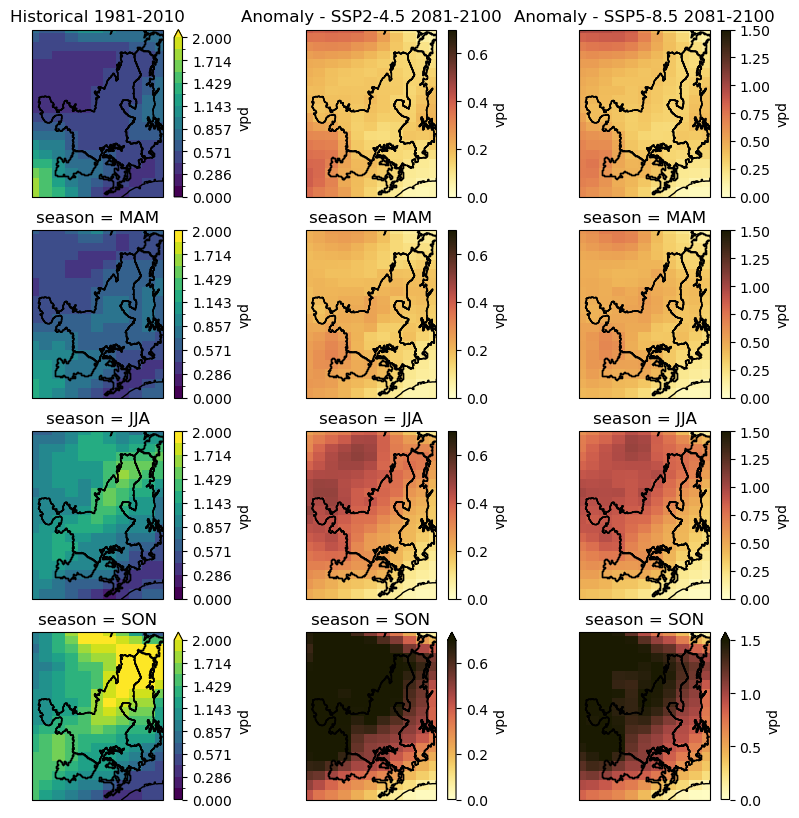

2023-04-20 14:47:23,612 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:52354', name: 3, status: running, memory: 0, processing: 0>
2023-04-20 14:47:23,649 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:52354'.
2023-04-20 17:40:00,577 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:52360', name: 1, status: running, memory: 0, processing: 0>
2023-04-20 17:40:00,594 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:52360'.
2023-04-20 17:40:03,483 - distributed.nanny - WARNING - Restarting worker


In [46]:

seasons = ['DJF', 'MAM', 'JJA', 'SON']
fig, ax = plt.subplots(4, 3, subplot_kw={'projection': proj_plot}, figsize=(10,10))



for i, sea in enumerate(seasons):
    ds_historical_vpd_clim_season.sel(season=sea).vpd.plot(ax=ax[i][0], transform=ccrs.PlateCarree(), cmap='viridis', levels = 15, vmax=2.0, vmin=0)
    ds_ssp245_vpd_anomaly_season.sel(season= sea).vpd.plot(ax=ax[i][1], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', vmin=0, vmax=0.7)
    ds_ssp585_vpd_anomaly_season.sel(season= sea).vpd.plot(ax=ax[i][2], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', vmin=0, vmax=1.5)

for i in ax.flat:    
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    i.coastlines()
    #set axis extend
    i.set_extent([-61, -42, -25, -2], crs=ccrs.PlateCarree())

ax[0][0].set_title('Historical 1981-2010')
ax[0][1].set_title('Anomaly - SSP2-4.5 2081-2100')
ax[0][2].set_title('Anomaly - SSP5-8.5 2081-2100') 

# All

In [15]:
ds_ssp245_pr_anomaly.to_netcdf(r'Data\CMIP6\plots\pr_ssp245_anomaly.nc')
ds_ssp585_pr_anomaly.to_netcdf(r'Data\CMIP6\plots\pr_ssp585_anomaly.nc')
ds_ssp245_vpd_anomaly.to_netcdf(r'Data\CMIP6\plots\vpd_ssp245_anomaly.nc')
ds_ssp585_vpd_anomaly.to_netcdf(r'Data\CMIP6\plots\vpd_ssp585_anomaly.nc')
ds_ssp245_ent_anomaly.to_netcdf(r'Data\CMIP6\plots\ent_ssp245_anomaly.nc')
ds_ssp585_ent_anomaly.to_netcdf(r'Data\CMIP6\plots\ent_ssp585_anomaly.nc')


Text(0.5, 1.0, 'Anomaly - SSP5-8.5 2071-2100')

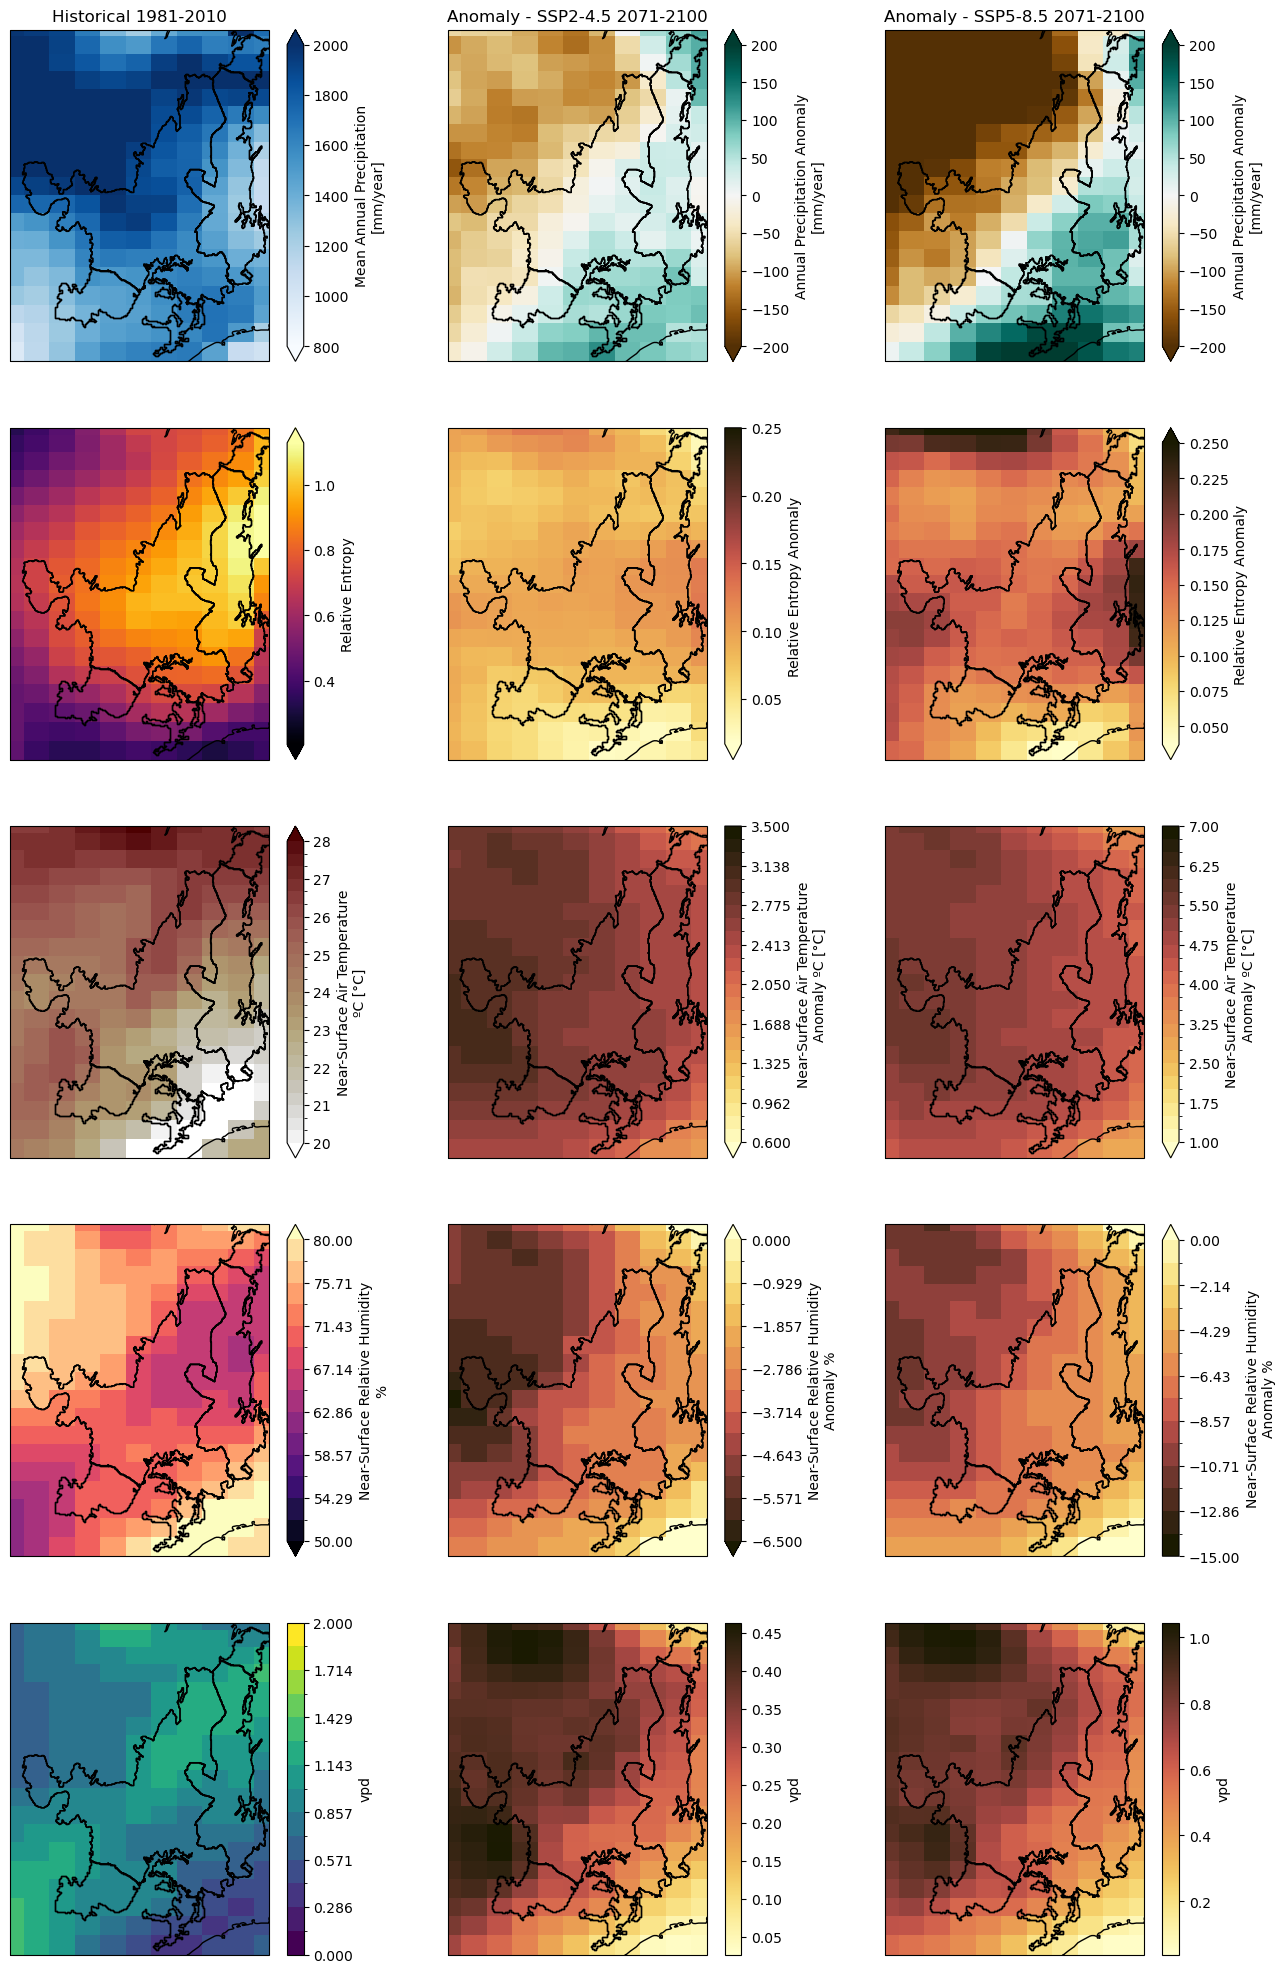

2023-04-20 10:39:28,811 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:52347', name: 0, status: running, memory: 0, processing: 0>
2023-04-20 10:39:28,819 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:52357', name: 2, status: running, memory: 0, processing: 0>
2023-04-20 10:39:28,827 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:52357'.
2023-04-20 10:39:28,835 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:52347'.


In [36]:
proj_plot = ccrs.Mercator()
fig, ax = plt.subplots(5, 3, figsize=(16, 25), subplot_kw={'projection': proj_plot})

ds_historical_pr_clim.pr.plot(ax=ax[0][0], transform=ccrs.PlateCarree(), vmin=800, vmax=2000, cmap='Blues')
ds_ssp245_pr_anomaly.pr.plot(ax=ax[0][1], transform=ccrs.PlateCarree(), vmin=-200, vmax=200, cmap='BrBG')
ds_ssp585_pr_anomaly.pr.plot(ax=ax[0][2], transform=ccrs.PlateCarree(), vmin=-200, vmax=200, cmap='BrBG')

ds_historical_ent_clim.entropy.plot(ax=ax[1][0], transform=ccrs.PlateCarree(), cmap='inferno', robust=True)
ds_ssp245_ent_anomaly.entropy.plot(ax=ax[1][1], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', robust=True, vmax=0.25)
ds_ssp585_ent_anomaly.entropy.plot(ax=ax[1][2], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', robust=True, vmax=0.25)

ds_historical_tas_clim.tas.plot(ax=ax[2][0], transform=ccrs.PlateCarree(), vmax=28, vmin=20, cmap='cmc.bilbao', levels = 25)
ds_ssp245_tas_anomaly.tas.plot(ax=ax[2][1], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', levels = 25, vmax=3.5, vmin=0.6)
ds_ssp585_tas_anomaly.tas.plot(ax=ax[2][2], transform=ccrs.PlateCarree(), cmap='cmc.lajolla', levels = 25, vmax=7, vmin=1)

ds_historical_hurs_clim.hurs.plot(ax=ax[3][0], transform=ccrs.PlateCarree(), cmap='magma', levels = 15, vmax=80, vmin=50)
ds_ssp245_hurs_anomaly.hurs.plot(ax=ax[3][1], transform=ccrs.PlateCarree(), cmap='cmc.lajolla_r', levels = 15, vmax=0, vmin=-6.5)
ds_ssp585_hurs_anomaly.hurs.plot(ax=ax[3][2], transform=ccrs.PlateCarree(), cmap='cmc.lajolla_r', levels = 15, vmax=0, vmin=-15)

#vpd
ds_historical_vpd_clim.vpd.plot(ax=ax[4][0], transform=ccrs.PlateCarree(), cmap='viridis', levels = 15, vmax=2.0, vmin=0)
ds_ssp245_vpd_anomaly.vpd.plot(ax=ax[4][1], transform=ccrs.PlateCarree(),  cmap='cmc.lajolla')
ds_ssp585_vpd_anomaly.vpd.plot(ax=ax[4][2], transform=ccrs.PlateCarree(),  cmap='cmc.lajolla')




for i in ax.flat:    
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    regions.plot(ax=i, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    i.coastlines()
    #set axis extend
    i.set_extent([-61, -42, -25, -2], crs=ccrs.PlateCarree())

#set axis titles
ax[0][0].set_title('Historical 1981-2010')
ax[0][1].set_title('Anomaly - SSP2-4.5 2071-2100')
ax[0][2].set_title('Anomaly - SSP5-8.5 2071-2100') 


# Vectors

In [24]:
#ds_historical_all.to_netcdf('Data\CMIP6\pr_historical_all_models.nc')
ds_historical_all = xr.open_dataset('Data\CMIP6\pr_historical_bests_models.nc')
ds_ssp585_all = xr.open_dataset('Data\CMIP6\pr_ssp585_bests_models.nc')
ds_ssp245_all = xr.open_dataset('Data\CMIP6\pr_ssp245_bests_models.nc')

ds_historical_ent = xr.open_dataset('Data\CMIP6\ent_historical_bests_models.nc')
ds_ssp585_all_ent = xr.open_dataset('Data\CMIP6\ent_ssp585_bests_models.nc')
ds_ssp245_all_ent = xr.open_dataset('Data\CMIP6\ent_ssp245_bests_models.nc')

#open vpd
ds_historical_all_vpd = xr.open_dataset(r'Data\CMIP6\vpd_historical_bests_models.nc')
ds_ssp585_all_vpd = xr.open_dataset(r'Data\CMIP6\vpd_ssp585_bests_models.nc')
ds_ssp245_all_vpd = xr.open_dataset(r'Data\CMIP6\vpd_ssp245_bests_models.nc')



In [25]:
ds_historical_pr_clim = ds_historical_all.mean(dim='model').mean(dim='time')
ds_ssp585_pr_clim = ds_ssp585_all.mean(dim='model').mean(dim='time')
ds_ssp245_pr_clim = ds_ssp245_all.mean(dim='model').mean(dim='time')

ds_historical_pr_clim['pr'] = ds_historical_pr_clim.pr * 12
ds_ssp245_pr_clim['pr'] = ds_ssp245_pr_clim.pr * 12
ds_ssp585_pr_clim['pr'] = ds_ssp585_pr_clim.pr * 12

ds_historical_ent_clim = ds_historical_ent.mean(dim='model').mean(dim='year')
ds_ssp585_ent_clim = ds_ssp585_all_ent.mean(dim='model').mean(dim='year')
ds_ssp245_ent_clim = ds_ssp245_all_ent.mean(dim='model').mean(dim='year')

ds_historical_vpd_clim = ds_historical_all_vpd.mean(dim='model').mean(dim='time')
ds_ssp585_vpd_clim = ds_ssp585_all_vpd.mean(dim='model').mean(dim='time')
ds_ssp245_vpd_clim = ds_ssp245_all_vpd.mean(dim='model').mean(dim='time')


In [26]:
ds_historical_pr_clim['entropy'] = ds_historical_ent_clim['entropy']
ds_historical_pr_clim['vpd'] = ds_historical_vpd_clim['vpd']
mask = cerrado_mask.mask(ds_historical_pr_clim, lon_name='lon', lat_name='lat')
ds_historical_pr_clim['mask'] = mask
df_historical = ds_historical_pr_clim.to_dataframe().reset_index().dropna()
df_historical['mask'].replace({0:'Central', 1:'Southern', 2:'Eastern'}, inplace=True)
#the same for the ssps
ds_ssp245_pr_clim['entropy'] = ds_ssp245_ent_clim['entropy']
ds_ssp245_pr_clim['vpd'] = ds_ssp245_vpd_clim['vpd']
mask = cerrado_mask.mask(ds_ssp245_pr_clim, lon_name='lon', lat_name='lat')
ds_ssp245_pr_clim['mask'] = mask
df_ssp245 = ds_ssp245_pr_clim.to_dataframe().reset_index().dropna()
df_ssp245['mask'].replace({0:'Central', 1:'Southern', 2:'Eastern'}, inplace=True)

ds_ssp585_pr_clim['entropy'] = ds_ssp585_ent_clim['entropy']
ds_ssp585_pr_clim['vpd'] = ds_ssp585_vpd_clim['vpd']
mask = cerrado_mask.mask(ds_ssp585_pr_clim, lon_name='lon', lat_name='lat')
ds_ssp585_pr_clim['mask'] = mask
df_ssp585 = ds_ssp585_pr_clim.to_dataframe().reset_index().dropna()
df_ssp585['mask'].replace({0:'Central', 1:'Southern', 2:'Eastern'}, inplace=True)


In [27]:
# Create a new dataframe with the vectors
df_vectors = pd.DataFrame({
    'pr': df_ssp585['pr'] - df_historical['pr'],
    'entropy': df_ssp585['entropy'] - df_historical['entropy'],
    'vpd' : df_ssp585['vpd'] - df_historical['vpd']})

dx=df_vectors['pr']
dy=df_vectors['entropy']
df_historical['Experiment'] = 'Historical'
df_ssp245['Experiment'] = 'SSP2-4.5'
df_ssp585['Experiment'] = 'SSP5-8.5'

dff = pd.concat([df_historical, df_ssp585, df_ssp245])

df_vectors245 = pd.DataFrame({
    'pr': df_ssp245['pr'] - df_historical['pr'],
    'entropy': df_ssp245['entropy'] - df_historical['entropy'],
    'vpd' : df_ssp245['vpd'] - df_historical['vpd']})

    
dff = dff.rename(columns={'mask':'Region'})

In [28]:
#sum of the vectors for each region
df_vectors['region'] = df_historical['mask']
df_vec_mean = df_vectors.groupby('region').mean()
df_historical_mean = df_historical.groupby('mask').mean()
df_vectors245['region'] = df_historical['mask']
df_vec_mean245 = df_vectors245.groupby('region').mean()

In [80]:
dff.to_csv('Data\joyplots\df_cmip6_joy.csv')
df_vectors.to_csv('Data\joyplots\df_ssp585_vectors_joy.csv')
df_vectors245.to_csv('Data\joyplots\df_ssp245_vectors_joy.csv')
df_historical_mean.to_csv('Data\joyplots\df_historical_vectors_mean_joy.csv')
df_vec_mean245.to_csv('Data\joyplots\df_ssp245_vectors_mean_joy.csv')
df_vec_mean.to_csv('Data\joyplots\df_ssp585_vectors_mean_joy.csv')

### season

In [81]:
#calculate the season mean
ds_historical_pr_clim_season = ds_historical_all.sel(model=bests).groupby('time.season').mean('time', keep_attrs=True).mean('model', keep_attrs=True)
ds_ssp585_all_pr_clim_season = ds_ssp585_all.sel(model=bests).groupby('time.season').mean('time').mean('model')
ds_ssp245_all_pr_clim_season = ds_ssp245_all.sel(model=bests).groupby('time.season').mean('time').mean('model')

#anomalies
ds_ssp245_pr_anomaly_season = (ds_ssp245_all_pr_clim_season - ds_historical_pr_clim_season)
ds_ssp585_pr_anomaly_season = (ds_ssp585_all_pr_clim_season - ds_historical_pr_clim_season)

In [88]:
mask = cerrado_mask.mask(ds_historical_pr_clim_season, lon_name='lon', lat_name='lat')
ds_historical_pr_clim_season['mask'] = mask
df_historical_season= ds_historical_pr_clim_season.to_dataframe().reset_index().dropna()
df_historical_season['mask'].replace({0:'Central', 1:'Southern', 2:'Eastern'}, inplace=True)


In [91]:
df_historical_season.groupby(['mask', 'season']).mean()

lat         lon          pr
mask     season                                   
Central  DJF    -13.869681  309.833777  334.534838
         JJA    -13.869681  309.833777    6.099721
         MAM    -13.869681  309.833777  145.294360
         SON    -13.869681  309.833777  105.451809
Eastern  DJF    -12.500000  315.187500  294.257612
         JJA    -12.500000  315.187500    4.687174
         MAM    -12.500000  315.187500  136.368159
         SON    -12.500000  315.187500   74.096774
Southern DJF    -21.041667  306.354167  242.693703
         JJA    -21.041667  306.354167   27.460875
         MAM    -21.041667  306.354167   88.956172
         SON    -21.041667  306.354167  123.954714

In [82]:
ds_historical_pr_clim['entropy'] = ds_historical_ent_clim['entropy']
ds_historical_pr_clim['vpd'] = ds_historical_vpd_clim['vpd']
mask = cerrado_mask.mask(ds_historical_pr_clim, lon_name='lon', lat_name='lat')
ds_historical_pr_clim['mask'] = mask
df_historical = ds_historical_pr_clim.to_dataframe().reset_index().dropna()
df_historical['mask'].replace({0:'Central', 1:'Southern', 2:'Eastern'}, inplace=True)
#the same for the ssps
ds_ssp245_pr_clim['entropy'] = ds_ssp245_ent_clim['entropy']
ds_ssp245_pr_clim['vpd'] = ds_ssp245_vpd_clim['vpd']
mask = cerrado_mask.mask(ds_ssp245_pr_clim, lon_name='lon', lat_name='lat')
ds_ssp245_pr_clim['mask'] = mask
df_ssp245 = ds_ssp245_pr_clim.to_dataframe().reset_index().dropna()
df_ssp245['mask'].replace({0:'Central', 1:'Southern', 2:'Eastern'}, inplace=True)

ds_ssp585_pr_clim['entropy'] = ds_ssp585_ent_clim['entropy']
ds_ssp585_pr_clim['vpd'] = ds_ssp585_vpd_clim['vpd']
mask = cerrado_mask.mask(ds_ssp585_pr_clim, lon_name='lon', lat_name='lat')
ds_ssp585_pr_clim['mask'] = mask
df_ssp585 = ds_ssp585_pr_clim.to_dataframe().reset_index().dropna()
df_ssp585['mask'].replace({0:'Central', 1:'Southern', 2:'Eastern'}, inplace=True)


<xarray.Dataset>
Dimensions:  (season: 4, lat: 26, lon: 16)
Coordinates:
  * lat      (lat) float64 -29.38 -28.12 -26.88 -25.62 ... -0.625 0.625 1.875
  * lon      (lon) float64 293.4 295.3 297.2 299.1 ... 315.9 317.8 319.7 321.6
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    pr       (season, lat, lon) float64 72.85 73.06 73.99 ... 15.2 21.05 26.28
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-...
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-HR.historical.Amo...
    regrid_method:                    bilinear